In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import requests
from PIL import Image
from io import BytesIO
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.auto import tqdm
import folium
from folium.plugins import HeatMap

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)

In [4]:
train_df = pd.read_csv("/kaggle/input/data-cdc/Data/train.csv")
test_df  = pd.read_csv("/kaggle/input/data-cdc/Data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (16209, 21)
Test shape : (5404, 20)


In [5]:
train_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

sqft_living: Total interior living space of the house.

sqft_above: Interior living space above ground level (excluding basement).

sqft_basement: Interior living space below ground level.

sqft_lot: Total land area of the property.

sqft_living15: Average living space of the nearest 15 neighboring houses.

sqft_lot15: Average lot size of the nearest 15 neighboring houses.

condition (1–5): Overall maintenance condition of the house.

grade (1–13): Construction quality and architectural design of the house.

view (0–4): Quality of the view from the property.

waterfront: Indicates whether the house is located on a waterfront (0 = No, 1 = Yes)

In [6]:
train_df.head()

id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   
3       705     2.0           0     0  ...      7        1150             90   
4     13356     1.0           0     0  ...      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  
0        9240  
1        3605  
2        7455  
3         750  
4        8071  

[5 rows x 21 columns]

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In [8]:
train_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [9]:
train_df["id"].nunique(), len(train_df)

(16110, 16209)

The training set contains 16,209 rows but only 16,110 unique house IDs, indicating a small number of duplicate property listings.

In [10]:
train_df[train_df["id"].duplicated()].head(10)

id             date    price  bedrooms  bathrooms  sqft_living  \
2435  5332200530  20150424T000000  1015000         5       2.50         2350   
3218  2892700041  20140714T000000   168000         3       1.50         1370   
3255  2767603612  20140512T000000   500000         2       2.25         1290   
3316  6021500970  20150407T000000   874950         2       1.00         1080   
4439  7977201065  20150305T000000   740000         3       1.75         1380   
4653  6632900574  20140806T000000   367500         5       3.00         2980   
5007  4305200070  20140519T000000   350000         3       2.25         1640   
5115  5101402435  20150304T000000   539000         3       2.25         1540   
5358  2143700830  20141006T000000   207000         4       2.50         2100   
5416  5127001320  20141125T000000   190000         3       1.75         1520   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
2435      4000     2.0           0     0  ...      9        2350   
3218      7439     1.0           0     0  ...      6        1370   
3255      1334     3.0           0     0  ...      8        1290   
3316      4000     1.0           0     0  ...      7        1080   
4439      4590     1.0           0     0  ...      7         930   
4653     10064     1.0           0     0  ...      7        1680   
5007      7200     2.0           0     0  ...      8        1640   
5115      5338     1.0           0     0  ...      7         770   
5358     19680     1.5           0     0  ...      6        2100   
5416      9600     1.0           0     0  ...      7        1520   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
2435              0      1993             0    98112  47.6265 -122.296   
3218              0      1963             0    98055  47.4499 -122.189   
3255              0      2007             0    98107  47.6719 -122.382   
3316              0      1940             0    98117  47.6902 -122.387   
4439            450      1950             0    98115  47.6841 -122.293   
4653           1300      1940             0    98155  47.7372 -122.316   
5007              0      1985             0    98007  47.5948 -122.153   
5115            770      1954             0    98115  47.6942 -122.304   
5358              0      1914             0    98055  47.4787 -122.230   
5416              0      1967             0    98059  47.4730 -122.149   

      sqft_living15  sqft_lot15  
2435           1840        4000  
3218           2350        3370  
3255           1350        1334  
3316           1530        4240  
4439           1320        4692  
4653           1590        7800  
5007           1830        8372  
5115           1680        6525  
5358           1340       12300  
5416           1590       10183  

[10 rows x 21 columns]

In [11]:
train_df["date"] = pd.to_datetime(train_df["date"])

Converting **20150305T000000** to **2015-03-05**

In [12]:
train_df.head()

id       date   price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  9117000170 2015-05-05  268643         4       2.25         1810      9240   
1  6700390210 2014-07-08  245000         3       2.50         1600      2788   
2  7212660540 2015-01-15  200000         4       2.50         1720      8638   
3  8562780200 2015-04-27  352499         2       2.25         1240       705   
4  7760400350 2014-12-05  232000         3       2.00         1280     13356   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     2.0           0     0  ...      7        1810              0      1961   
1     2.0           0     0  ...      7        1600              0      1992   
2     2.0           0     0  ...      8        1720              0      1994   
3     2.0           0     0  ...      7        1150             90      2009   
4     1.0           0     0  ...      7        1280              0      1994   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98055  47.4362 -122.187           1660        9240  
1             0    98031  47.4034 -122.187           1720        3605  
2             0    98003  47.2704 -122.313           1870        7455  
3             0    98027  47.5321 -122.073           1240         750  
4             0    98042  47.3715 -122.074           1590        8071  

[5 rows x 21 columns]

In [13]:
train_df = (train_df.sort_values("date").drop_duplicates(subset="id", keep="last").reset_index(drop=True))

If two ids are same then we are keeping the recent one.

In [14]:
train_df["id"].nunique(), len(train_df)

(16110, 16110)

Now all are unique.

In [15]:
train_df["image_path"] = train_df["id"].apply(
    lambda x: os.path.join("/kaggle/input/data-cdc/Data/images_train", f"{x}.png")
)

In [16]:
train_df["image_path"].head()

0    /kaggle/input/data-cdc/Data/images_train/75254...
1    /kaggle/input/data-cdc/Data/images_train/51014...
2    /kaggle/input/data-cdc/Data/images_train/27711...
3    /kaggle/input/data-cdc/Data/images_train/44081...
4    /kaggle/input/data-cdc/Data/images_train/50565...
Name: image_path, dtype: object

In [17]:
train_df['image_path'].isnull().sum()

np.int64(0)

I have already downloaded all the files using GoogleMaps Static API.

In [18]:
## Only if missing is not null

# missing_images = 0
# for path in train_df["image_path"]:
#     if not os.path.exists(path):
#         missing_images += 1
#         print(f"Missing: {path}")
# print(f"Missing images in sample: {missing_images}")

No missing image

### Price Distribution

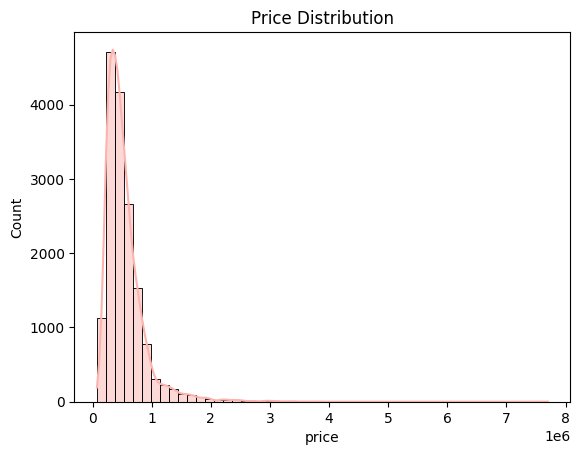

In [19]:
sns.histplot(train_df['price'], bins=50, kde=True, color=sns.color_palette("Pastel1")[0])
plt.title('Price Distribution')
plt.show()

In [20]:
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [21]:
num_cols.remove('id')
num_cols.remove('zipcode')

### Correlation Matrix

In [22]:
corr_matrix = train_df[num_cols].corr()

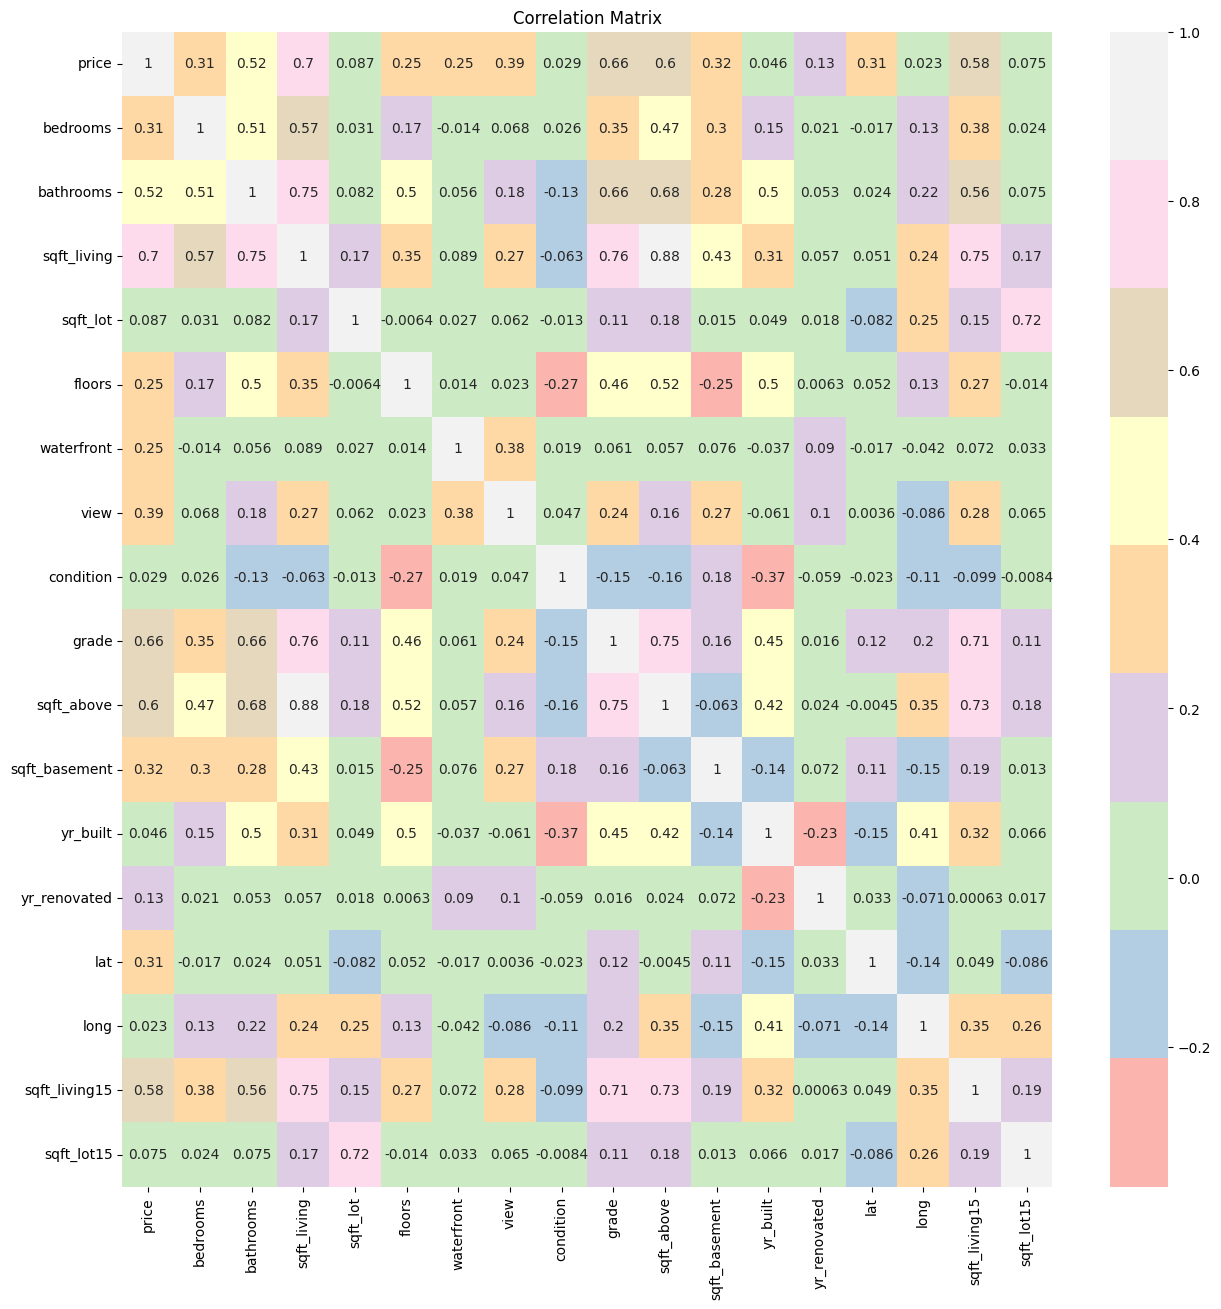

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True,cmap='Pastel1')
plt.title('Correlation Matrix')
plt.show()

After doing the first iteration of EDA we found that these are the outliers and affects are analysis as well as models by a margin so taking them as outlier and dropping them.

In [24]:
count_sqft_outliers = (
    (train_df["sqft_living"] > 5000) |
    (train_df["sqft_lot"] > 100000)
).sum()

count_sqft_outliers


np.int64(474)

In [25]:
before = train_df.shape[0]

train_df = train_df[
    (train_df["sqft_living"] <= 5000) &
    (train_df["sqft_lot"] <= 100000)
].copy()


after = train_df.shape[0]

print(f"Dropped {before - after} rows ({(before - after)/before*100:.2f}%)")

Dropped 474 rows (2.94%)


In [26]:
train_df['dist_to_seattle'] = np.sqrt((train_df['lat'] - 47.6062)**2 + (train_df['long'] + 122.3321)**2)

### Distribution of Bathrooms, Bedrooms and floors

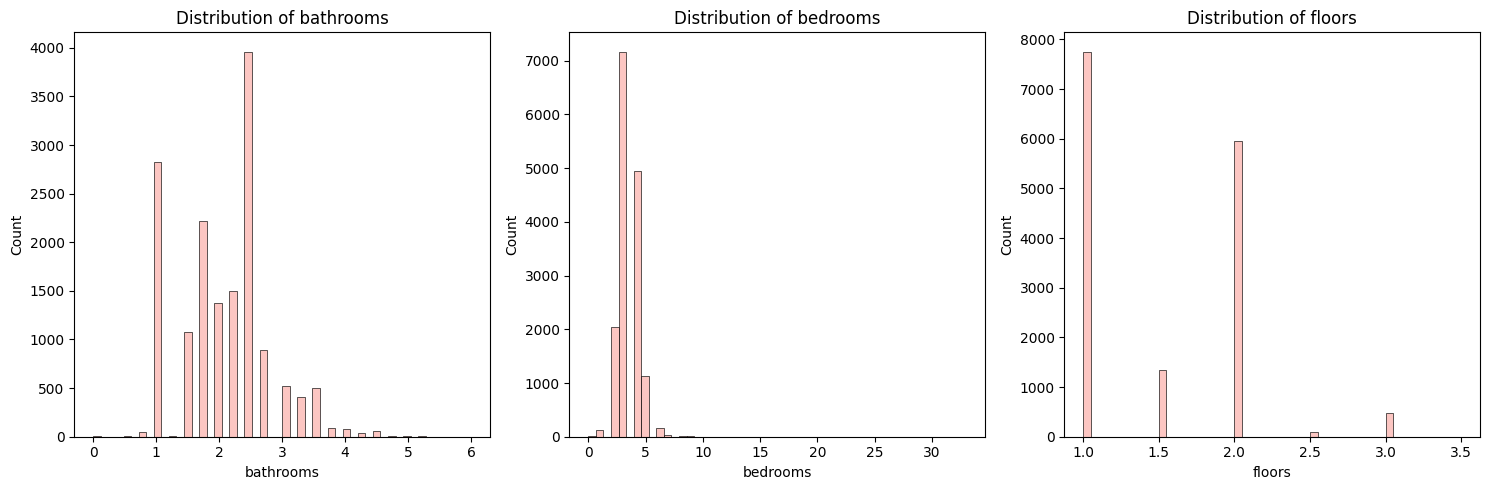

In [27]:
key_features = ["bathrooms","bedrooms","floors"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for ax, col in zip(axes, key_features):
    sns.histplot(
        train_df[col],
        bins=50,
        color=sns.color_palette("Pastel1")[0],
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

for i in range(len(key_features), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Average House Price vs Bathrooms, Bedrooms and floors

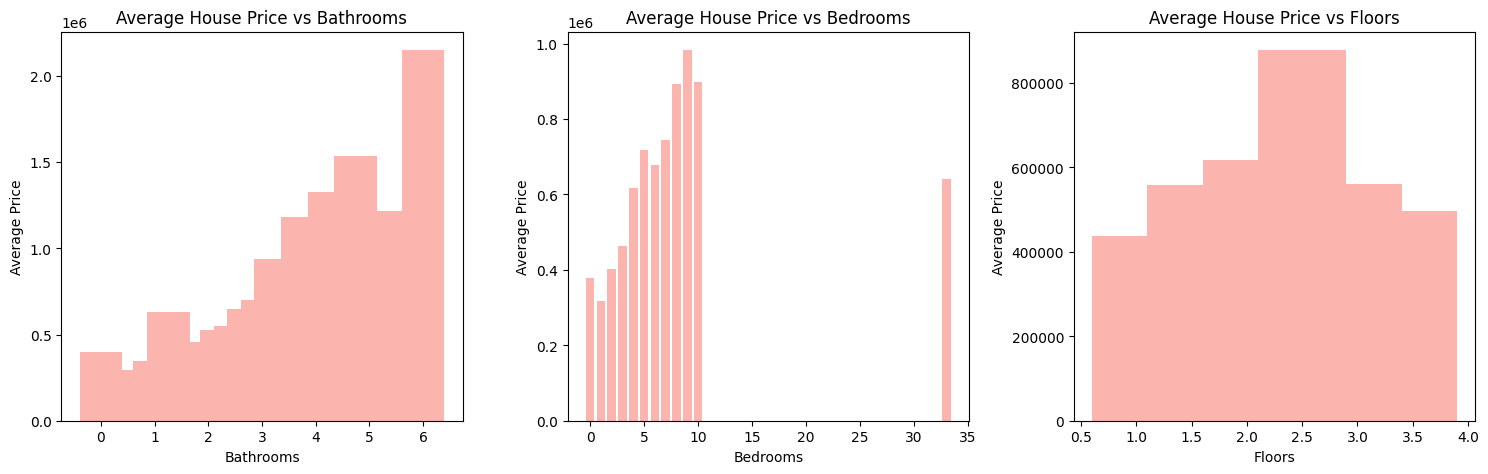

In [28]:
key_features = ["bathrooms","bedrooms","floors"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for ax, col in zip(axes, key_features):
    avg_price = (
        train_df
        .groupby(col)["price"]
        .mean()
        .reset_index()
        .sort_values(col)
    )

    ax.bar(avg_price[col], avg_price["price"],color=sns.color_palette("Pastel1")[0])
    ax.set_title(f"Average House Price vs {col.capitalize()}")
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel("Average Price")

plt.tight_layout()
plt.show()


### Distribution of SquareFeetLiving, SquareFeetLot, SquareFeetLiving15, SquareFeetLot15

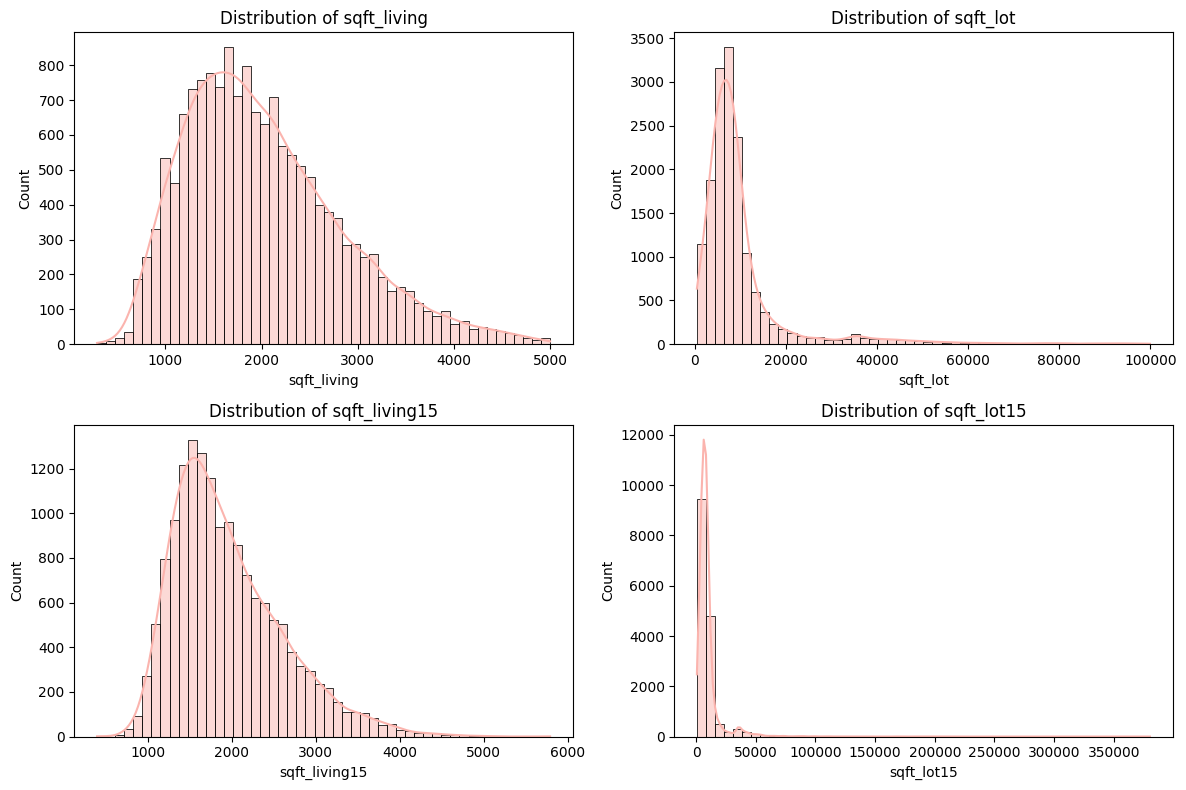

In [29]:
dist_features = ["sqft_living", "sqft_lot","sqft_living15", "sqft_lot15"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, dist_features):
    sns.histplot(
        train_df[col],
        bins=50,
        color=sns.color_palette("Pastel1")[0],
        kde=True,
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

for i in range(len(dist_features), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### Average Price vs SquareFeetLiving, SquareFeetLot, SquareFeetLiving15, SquareFeetLot15

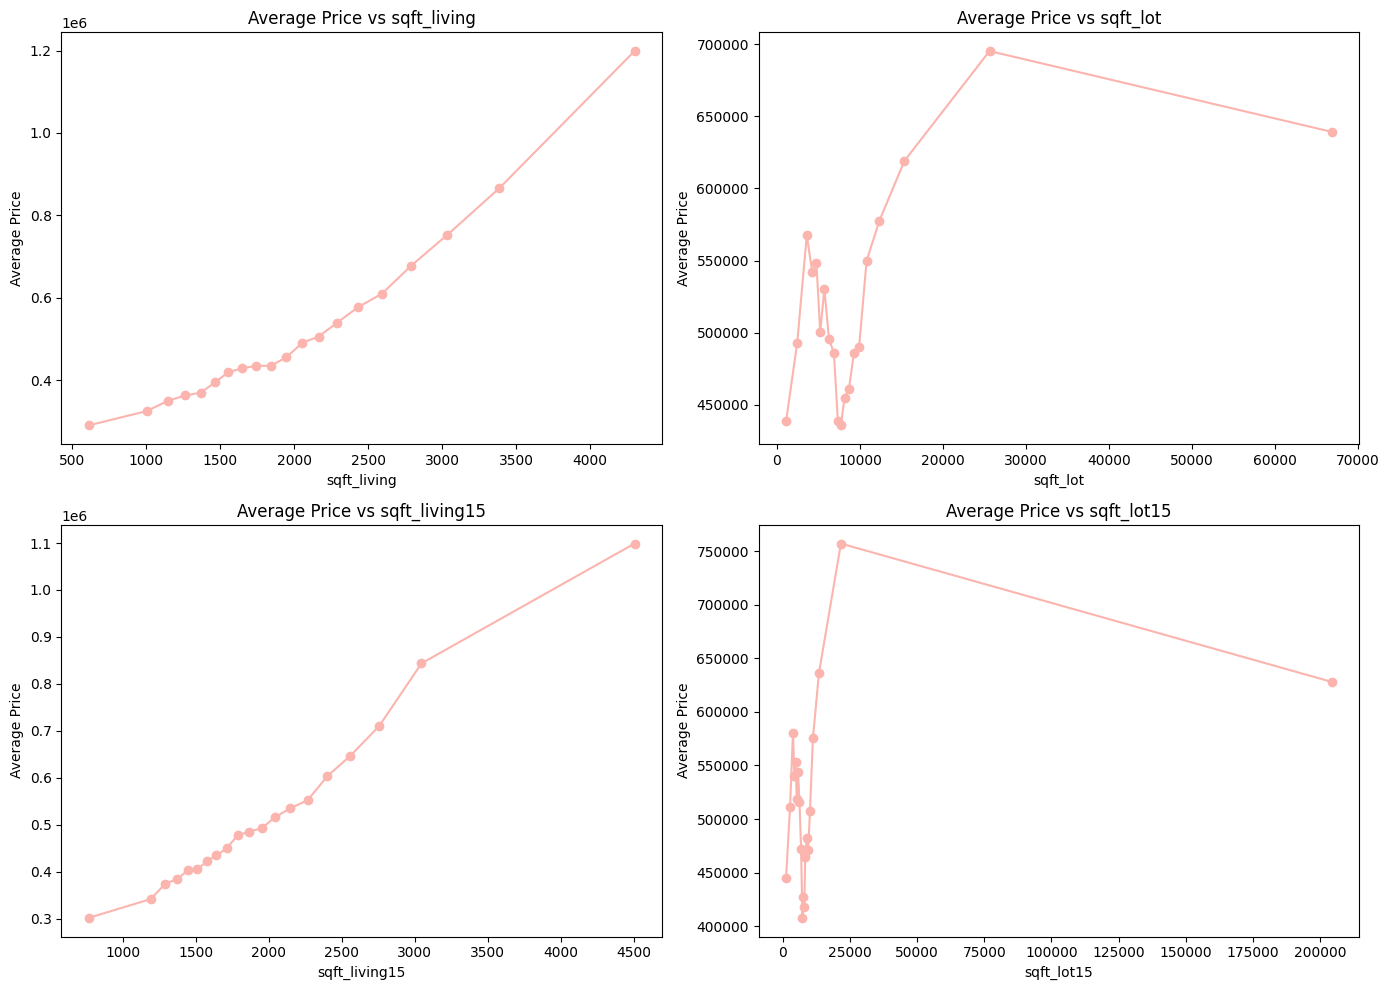

In [30]:
dist_features = ["sqft_living", "sqft_lot", "sqft_living15", "sqft_lot15"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, col in zip(axes, dist_features):
    # Create bins
    bins = pd.qcut(train_df[col], q=20, duplicates="drop")

    avg_price = (
        train_df
        .groupby(bins)["price"]
        .mean()
        .reset_index()
    )

    bin_mid = avg_price[col].apply(lambda x: x.mid)

    ax.plot(bin_mid, avg_price["price"], marker="o",color=sns.color_palette("Pastel1")[0])
    ax.set_title(f"Average Price vs {col}")
    ax.set_xlabel(col)

    ax.set_ylabel("Average Price")

plt.tight_layout()
plt.show()


### Boxplot for Categorical Data WaterFront, View, Condition, Grade

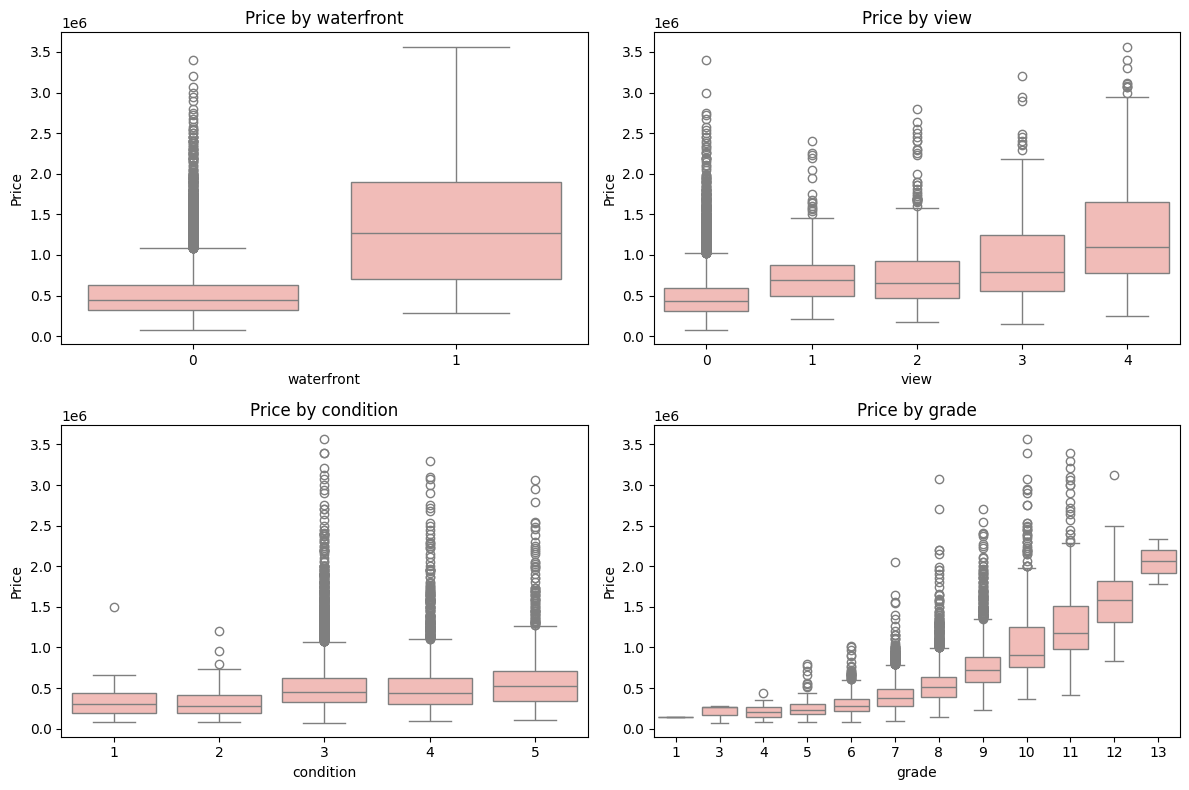

In [31]:
cat_like = ["waterfront", "view", "condition", "grade"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, cat_like):
    sns.boxplot(
        x=train_df[col],
        y=train_df["price"],
        color=sns.color_palette("Pastel1")[0],
        ax=ax
    )
    ax.set_title(f"Price by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()


In [32]:
# Load world map
world = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip')

# Load world countries
countries = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip')

# Filter for USA only
usa = countries[countries['NAME'] == 'United States of America']

# Load US states data
states = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip')

# Filter for Washington state only
wa = states[states['postal'] == 'WA']

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(train_df['long'], train_df['lat'])]
gdf = gpd.GeoDataFrame(train_df, geometry=geometry, crs='EPSG:4326')

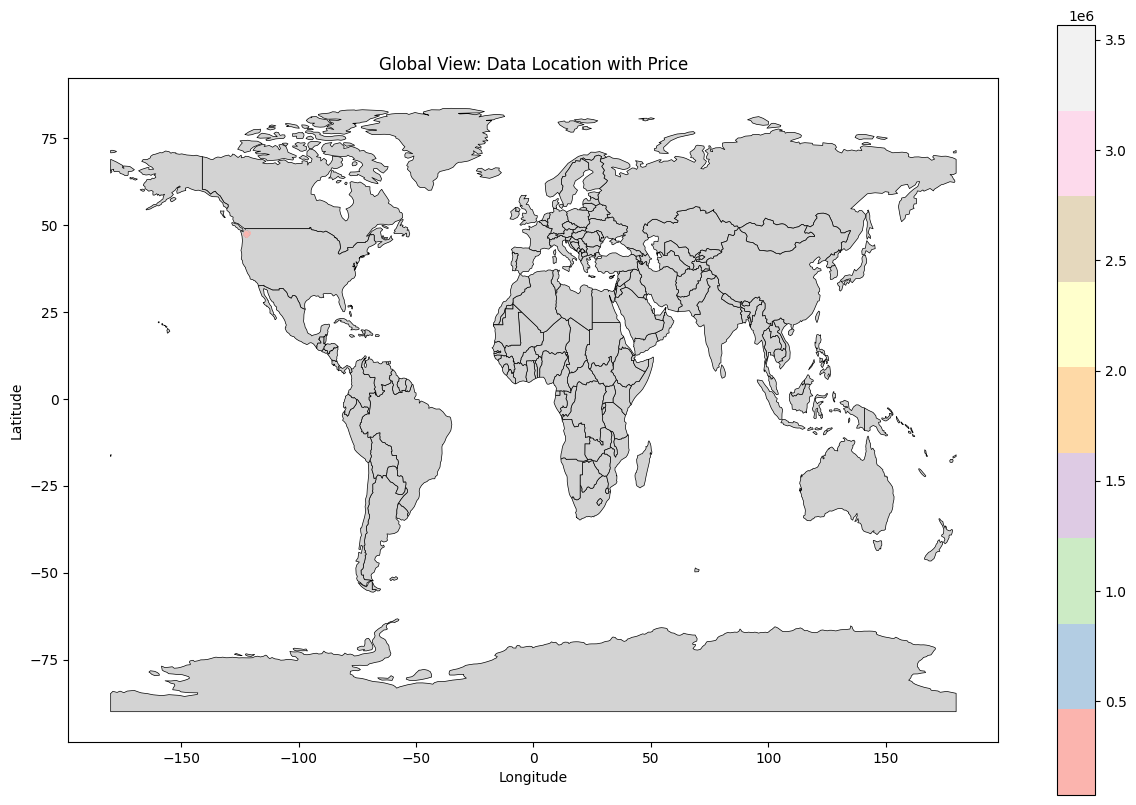

In [33]:
# Plot with price colors
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)
gdf.plot(ax=ax, column='price', cmap='Pastel1', markersize=5, alpha=0.7, legend=True)
ax.set_title('Global View: Data Location with Price')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

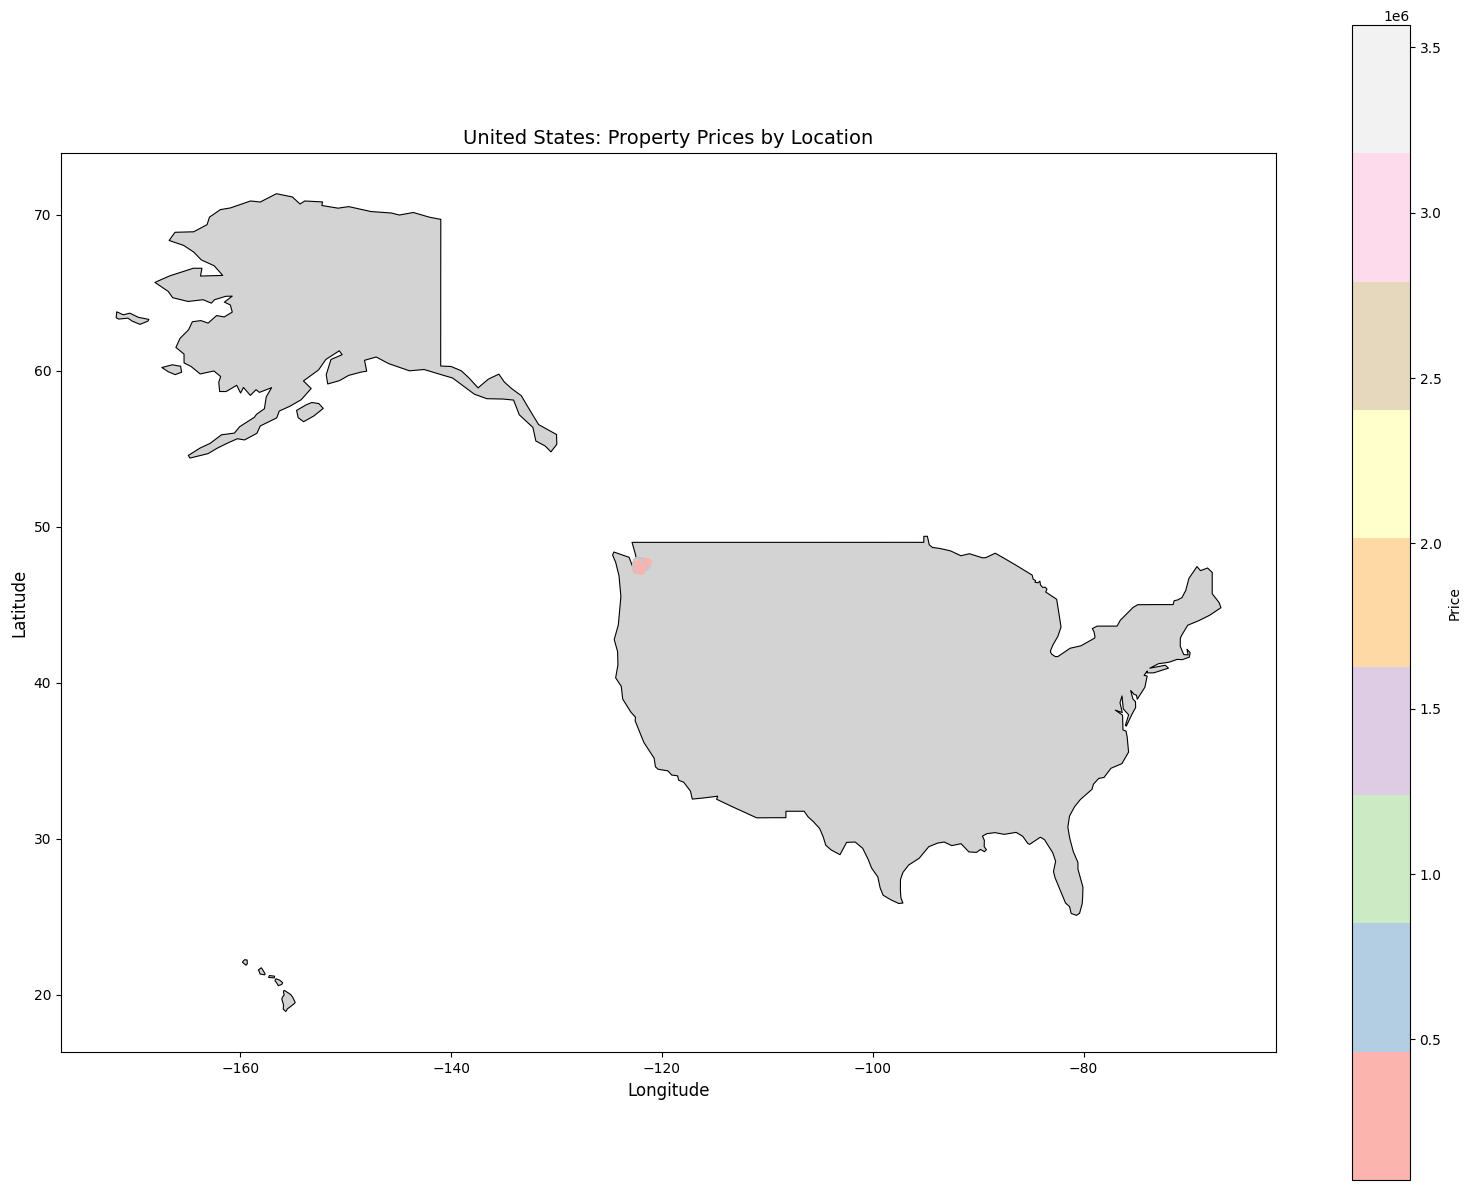

In [34]:
# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(train_df['long'], train_df['lat'])]
gdf = gpd.GeoDataFrame(train_df, geometry=geometry, crs='EPSG:4326')

# Plot USA
fig, ax = plt.subplots(figsize=(16, 12))
usa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.8)
gdf.plot(ax=ax, column='price', cmap='Pastel1', markersize=20,
         alpha=0.7, legend=True, legend_kwds={'label': 'Price'})

ax.set_title('United States: Property Prices by Location', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

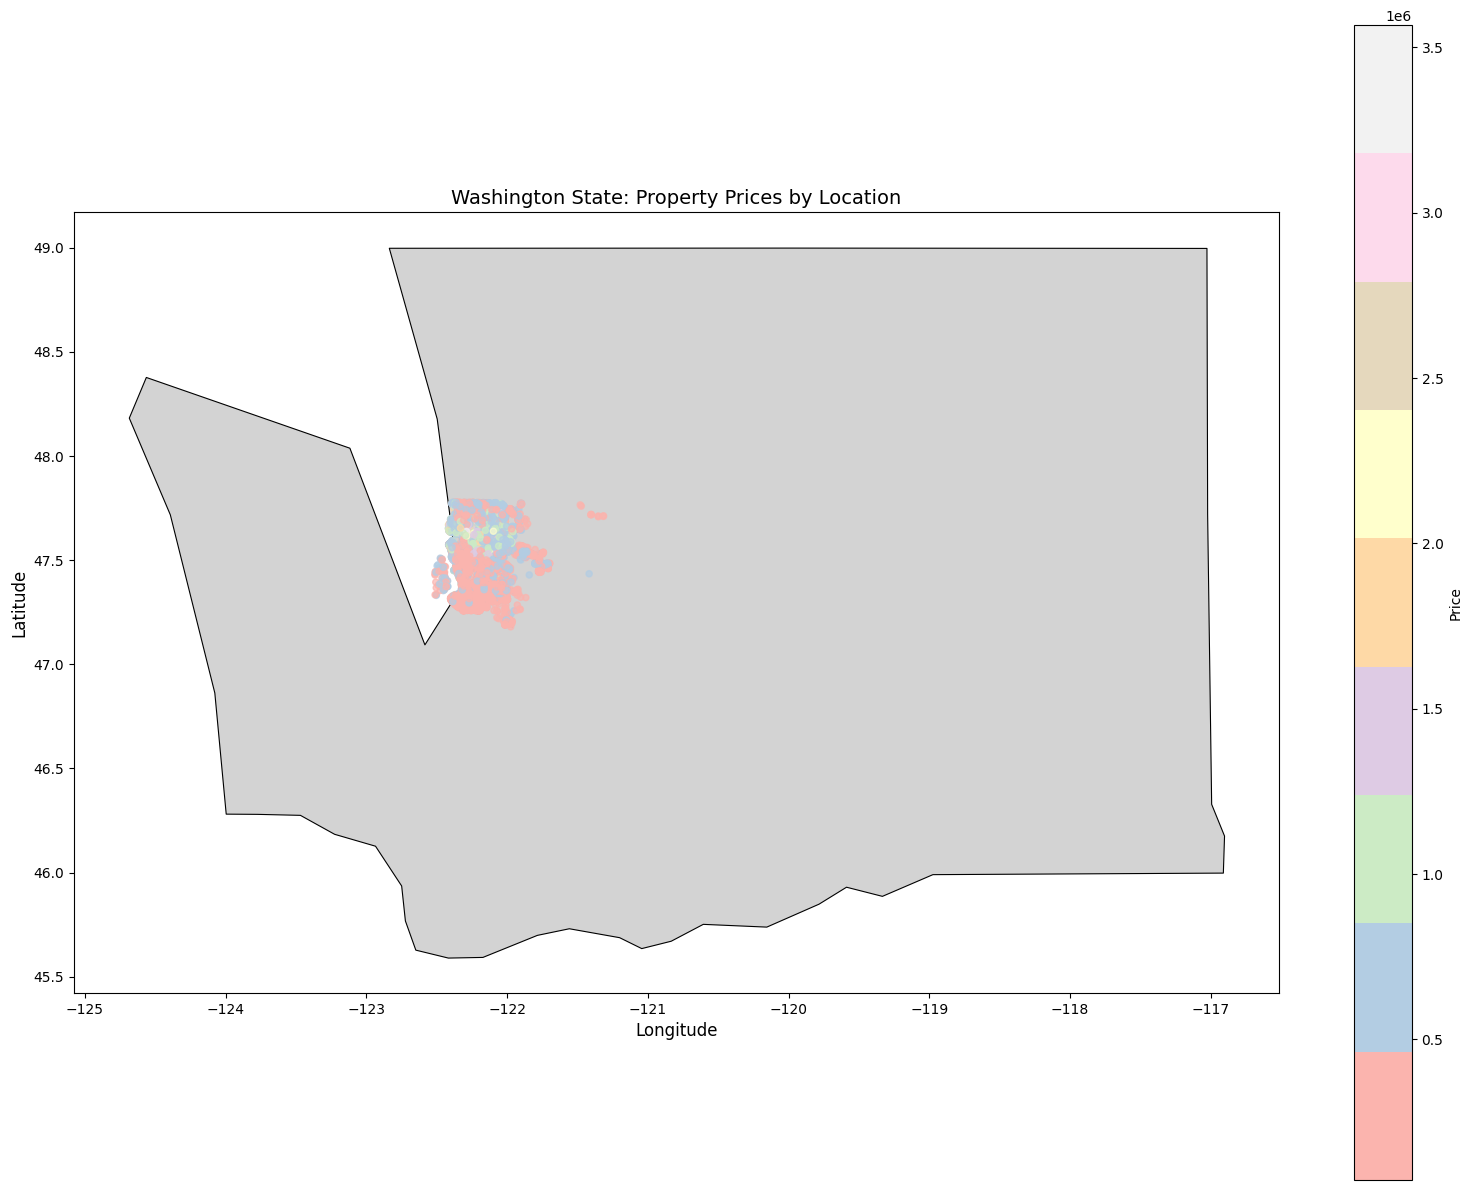

In [35]:
# Plot Washington
fig, ax = plt.subplots(figsize=(16, 12))
wa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.8)
gdf.plot(ax=ax, column='price', cmap='Pastel1', markersize=20,
         alpha=0.7, legend=True, legend_kwds={'label': 'Price'})

ax.set_title('Washington State: Property Prices by Location', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
maxpr=train_df.loc[train_df['price'].idxmax()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = train_df.copy()
df_copy['count'] = 1
basemap = generateBaseMap()


s=folium.FeatureGroup(name='icon').add_to(basemap)


folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)


HeatMap(data=df_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

This map visualizes the geographic distribution of properties using a heatmap, with the highest-priced house highlighted to show spatial price concentration patterns.

### Impact of Renovation on House Price

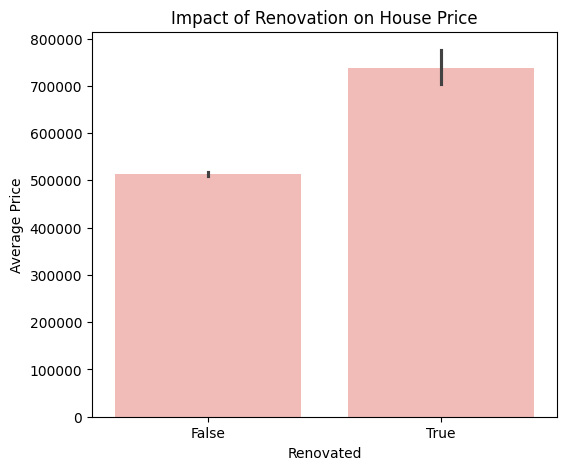

In [37]:
train_df["is_renovated"] = train_df["yr_renovated"] > 0

plt.figure(figsize=(6, 5))
sns.barplot(
    x=train_df["is_renovated"],
    y=train_df["price"],
    estimator=np.mean,
    color=sns.color_palette("Pastel1")[0]
)
plt.xlabel("Renovated")
plt.ylabel("Average Price")
plt.title("Impact of Renovation on House Price")
plt.show()


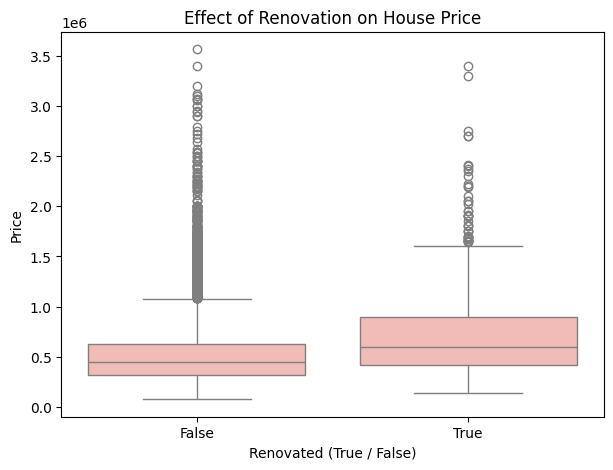

In [38]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    x=(train_df["yr_renovated"] > 0),
    y=train_df["price"],
    color=sns.color_palette("Pastel1")[0]
)
plt.xlabel("Renovated (True / False)")
plt.ylabel("Price")
plt.title("Effect of Renovation on House Price")
plt.show()

### Impact of House Age on House Price

In [39]:
REFERENCE_YEAR = 2020

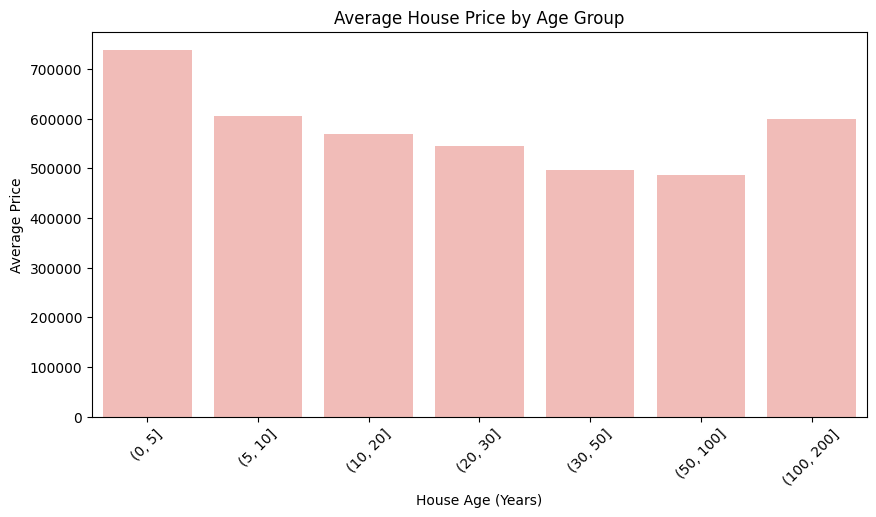

In [40]:
house_age = REFERENCE_YEAR - train_df["yr_built"]
age_bins = pd.cut(
    house_age,
    bins=[0, 5, 10, 20, 30, 50, 100, 200]
)
age_price = (
    train_df
    .assign(house_age=house_age, age_bin=age_bins)
    .groupby("age_bin")["price"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=age_price["age_bin"].astype(str),
    y=age_price["price"],
    color=sns.color_palette("Pastel1")[0]
)
plt.xlabel("House Age (Years)")
plt.ylabel("Average Price")
plt.title("Average House Price by Age Group")
plt.xticks(rotation=45)
plt.show()

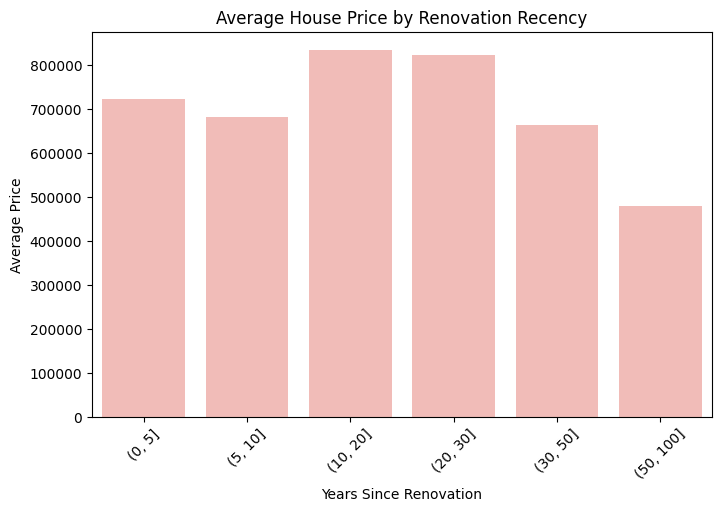

In [41]:
renovated_df = train_df[train_df["yr_renovated"] > 0].copy()
years_since_reno = REFERENCE_YEAR - renovated_df["yr_renovated"]

reno_bins = pd.cut(
    years_since_reno,
    bins=[0, 5, 10, 20, 30, 50, 100]
)

reno_price = (
    renovated_df
    .assign(years_since_reno=years_since_reno, reno_bin=reno_bins)
    .groupby("reno_bin")["price"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(8, 5))
sns.barplot(
    x=reno_price["reno_bin"].astype(str),
    y=reno_price["price"],
    color=sns.color_palette("Pastel1")[0]
)
plt.xlabel("Years Since Renovation")
plt.ylabel("Average Price")
plt.title("Average House Price by Renovation Recency")
plt.xticks(rotation=45)
plt.show()


In [42]:
train_df["zipcode"].nunique()

70

In [43]:
train_df["zipcode"].min(), train_df["zipcode"].max()

(98001, 98199)

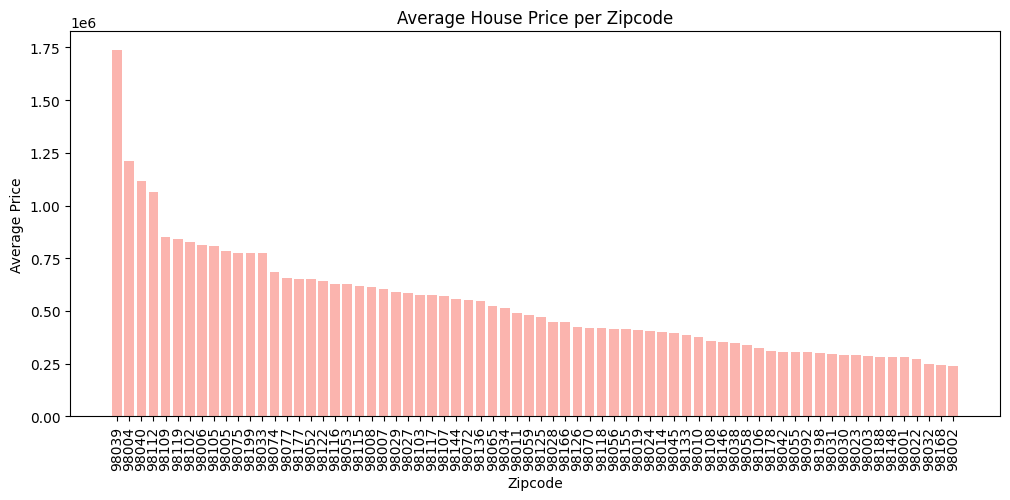

In [44]:
zip_price = (
    train_df
    .groupby("zipcode")["price"]
    .mean()
    .reset_index()
    .sort_values(by="price", ascending=False)
)

plt.figure(figsize=(12,5))
plt.bar(zip_price["zipcode"].astype(str), zip_price["price"],color=sns.color_palette("Pastel1")[0])
plt.xticks(rotation=90)
plt.xlabel("Zipcode")
plt.ylabel("Average Price")
plt.title("Average House Price per Zipcode")
plt.show()


In [45]:
top_10_zipcodes = (
    train_df
    .groupby("zipcode")["price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top_10_zipcodes

zipcode
98039    1.739588e+06
98004    1.209160e+06
98040    1.117871e+06
98112    1.065476e+06
98109    8.528373e+05
98119    8.436918e+05
98102    8.257470e+05
98006    8.116002e+05
98105    8.068600e+05
98005    7.856521e+05
Name: price, dtype: float64

**Why are prices higher in these zipcodes?**

These zipcodes cover premium suburbs and some of the best localities in Washington (WA), such as Medina and Bellevue, known for waterfront views, excellent infrastructure, and proximity to major employment hubs. High demand and limited housing supply in these areas lead to significantly higher average house prices.

# Tabular-Only Baseline Model

In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15636 entries, 0 to 16109
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               15636 non-null  int64         
 1   date             15636 non-null  datetime64[ns]
 2   price            15636 non-null  int64         
 3   bedrooms         15636 non-null  int64         
 4   bathrooms        15636 non-null  float64       
 5   sqft_living      15636 non-null  int64         
 6   sqft_lot         15636 non-null  int64         
 7   floors           15636 non-null  float64       
 8   waterfront       15636 non-null  int64         
 9   view             15636 non-null  int64         
 10  condition        15636 non-null  int64         
 11  grade            15636 non-null  int64         
 12  sqft_above       15636 non-null  int64         
 13  sqft_basement    15636 non-null  int64         
 14  yr_built         15636 non-null  int64     

In [47]:
train_df.head()

id       date   price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7525410190 2014-05-02  550000         3       1.75         2910     35200   
1  5101405331 2014-05-02  495000         4       1.75         1600      6380   
2  2771102144 2014-05-02  385000         3       3.25         1320      1327   
3  4408100095 2014-05-02  308500         2       1.00          850      6174   
4  5056500260 2014-05-02  440000         4       2.25         2160      8119   

   floors  waterfront  view  ...  yr_built  yr_renovated  zipcode      lat  \
0     1.5           0     0  ...      1979             0    98075  47.5747   
1     1.0           0     0  ...      1959             0    98125  47.7010   
2     2.0           0     0  ...      2008             0    98199  47.6506   
3     1.0           0     0  ...      1950             0    98155  47.7352   
4     1.0           0     0  ...      1966             0    98006  47.5443   

      long  sqft_living15  sqft_lot15  \
0 -122.035           2590       37500   
1 -122.306           1090        6380   
2 -122.383           1440        1263   
3 -122.328           1100        6174   
4 -122.177           1850        9000   

                                          image_path  dist_to_seattle  \
0  /kaggle/input/data-cdc/Data/images_train/75254...         0.298765   
1  /kaggle/input/data-cdc/Data/images_train/51014...         0.098327   
2  /kaggle/input/data-cdc/Data/images_train/27711...         0.067544   
3  /kaggle/input/data-cdc/Data/images_train/44081...         0.129065   
4  /kaggle/input/data-cdc/Data/images_train/50565...         0.166996   

   is_renovated  
0         False  
1         False  
2         False  
3         False  
4         False  

[5 rows x 24 columns]

In [48]:
train_df["house_age"] = REFERENCE_YEAR - train_df["yr_built"]

train_df["years_since_reno"] = np.where(
    train_df["yr_renovated"] > 0,
    REFERENCE_YEAR - train_df["yr_renovated"],
    0
)

In [49]:
train_df_split, val_df_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

In [50]:
TARGET = "price"

TABULAR_FEATURES_tab = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "house_age",
    "years_since_reno",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15",
    "dist_to_seattle"
]

In [51]:
# Then derive tabular features from the splits
X_train_only_tabular = train_df_split[TABULAR_FEATURES_tab]
X_val_only_tabular = val_df_split[TABULAR_FEATURES_tab]
y_train_only_tabular = train_df_split[TARGET]
y_val_only_tabular = val_df_split[TARGET]

## Linear Regression

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
X_train_only_tabular_lr = X_train_only_tabular
X_val_only_tabular_lr = X_val_only_tabular
y_train_only_tabular_lr = y_train_only_tabular
y_val_only_tabular_lr = y_val_only_tabular

In [54]:
lr_model = LinearRegression()
lr_model.fit(X_train_only_tabular_lr, y_train_only_tabular_lr)

LinearRegression()

In [55]:
import joblib
joblib.dump(lr_model, 'lr_model.pkl')

['lr_model.pkl']

In [56]:
y_pred_only_tabular_lr = lr_model.predict(X_val_only_tabular_lr)
rmse_only_tabular_lr = np.sqrt(mean_squared_error(y_val_only_tabular_lr, y_pred_only_tabular_lr))
r2_only_tabular_lr   = r2_score(y_val_only_tabular_lr, y_pred_only_tabular_lr)
rmse_only_tabular_lr, r2_only_tabular_lr

(np.float64(176754.19671816277), 0.6973833648633253)

## Polynomial Regression

In [57]:
from sklearn.preprocessing import PolynomialFeatures

In [58]:
X_train_only_tabular_poly = X_train_only_tabular
X_val_only_tabular_poly = X_val_only_tabular
y_train_only_tabular_poly = y_train_only_tabular
y_val_only_tabular_poly = y_val_only_tabular

In [59]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [60]:
X_train_poly_exp = poly.fit_transform(X_train_only_tabular_poly)
X_val_poly_exp   = poly.transform(X_val_only_tabular_poly)

In [61]:
poly_model = LinearRegression()
poly_model.fit(X_train_poly_exp, y_train_only_tabular_poly)

LinearRegression()

In [62]:
joblib.dump(poly_model, 'poly_model.pkl')
joblib.dump(poly, 'poly_features.pkl') 

['poly_features.pkl']

In [63]:
y_pred_only_tabular_poly = poly_model.predict(X_val_poly_exp)

In [64]:
rmse_only_tabular_poly = np.sqrt(mean_squared_error(y_val_only_tabular_poly, y_pred_only_tabular_poly))
r2_only_tabular_poly   = r2_score(y_val_only_tabular_poly, y_pred_only_tabular_poly)
rmse_only_tabular_poly, r2_only_tabular_poly

(np.float64(146156.3125371933), 0.7930866631873521)

## XGBoost

In [65]:
scaler_xgb = StandardScaler()

X_train_scaled_only_tabular_xgb = scaler_xgb.fit_transform(X_train_only_tabular)
X_val_scaled_only_tabular_xgb   = scaler_xgb.transform(X_val_only_tabular)
y_train_only_tabular_xgb = y_train_only_tabular
y_val_only_tabular_xgb = y_val_only_tabular

In [66]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,  
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1, 
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled_only_tabular_xgb, y_train_only_tabular_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [67]:
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler_xgb, 'scaler_xgb.pkl') 

['scaler_xgb.pkl']

In [68]:
y_pred_only_tabular_xgb = xgb_model.predict(X_val_scaled_only_tabular_xgb)

rmse_only_tabular_xgb = np.sqrt(mean_squared_error(y_val_only_tabular_xgb, y_pred_only_tabular_xgb))
r2_only_tabular_xgb  = r2_score(y_val_only_tabular_xgb, y_pred_only_tabular_xgb)

print(rmse_only_tabular_xgb, r2_only_tabular_xgb)

112144.50563447145 0.878182590007782


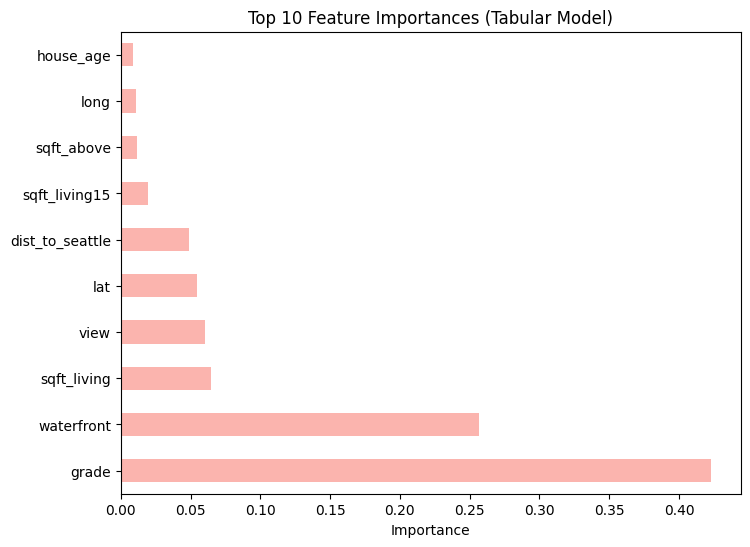

In [69]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=TABULAR_FEATURES_tab
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
importance.head(10).plot(kind="barh",color=sns.color_palette("Pastel1")[0])
plt.title("Top 10 Feature Importances (Tabular Model)")
plt.xlabel("Importance")
plt.show()

As Expected these features would have greater infulence on HousePrice

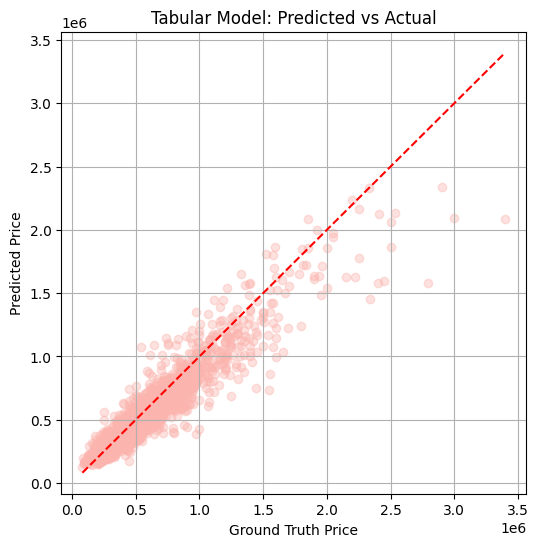

In [70]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_only_tabular_xgb, y_pred_only_tabular_xgb, alpha=0.4,color=sns.color_palette("Pastel1")[0])
plt.plot(
    [y_val_only_tabular_xgb.min(), y_val_only_tabular_xgb.max()],
    [y_val_only_tabular_xgb.min(), y_val_only_tabular_xgb.max()],
    'r--'
)
plt.xlabel("Ground Truth Price")
plt.ylabel("Predicted Price")
plt.title("Tabular Model: Predicted vs Actual")
plt.grid(True)
plt.show()


# Image-only CNN model

In [71]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [72]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [73]:
class HouseImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.valid_indices = []
        print("Checking for valid images...")
        for idx in tqdm(range(len(self.df)), desc="Validating images"):
            img_path = os.path.join(self.image_dir, f"{self.df.iloc[idx]['id']}.png")
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
        
        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")
        
        if len(self.valid_indices) == 0:
            raise ValueError("No valid images found! Check your image_dir path.")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.png")

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (128, 128, 128))

        if self.transform:
            image = self.transform(image)

        price = row["price"] / 1e6
        # !!! Normalising the price as my architecture fits this best.


        return image, torch.tensor(price, dtype=torch.float32)

### I am using ResNet18 for my architecture.

In [74]:
class ImageRegressor(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        
        # Using ResNet18 with pretrained weights 
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        for param in self.backbone.parameters():
            param.requires_grad = True

        
        num_features = self.backbone.fc.in_features  
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.backbone(x).squeeze(1)


In [75]:
print("\n" + "="*70)
print("DATA PREPARATION")
print("="*70)

print(f"Original dataset size: {len(train_df)}")
print(f"Train samples: {len(train_df_split)}")
print(f"Val samples: {len(val_df_split)}")


DATA PREPARATION
Original dataset size: 15636
Train samples: 12508
Val samples: 3128


In [76]:
# Create datasets
IMAGE_DIR = "/kaggle/input/data-cdc/Data/images_train"

In [77]:
train_dataset = HouseImageDataset(
    train_df_split,
    image_dir=IMAGE_DIR,
    transform=train_transform,
)

val_dataset = HouseImageDataset(
    val_df_split,
    image_dir=IMAGE_DIR,
    transform=val_transform,
)

Checking for valid images...


Validating images:   0%|          | 0/12508 [00:00<?, ?it/s]

✓ Found 12508/12508 valid images
Checking for valid images...


Validating images:   0%|          | 0/3128 [00:00<?, ?it/s]

✓ Found 3128/3128 valid images


In [78]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,  
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [79]:
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 781
Val batches: 196



SANITY CHECK
✓ Batch shape: torch.Size([16, 3, 224, 224])
✓ Target shape: torch.Size([16])
Price range: $0 to $2
Normalised


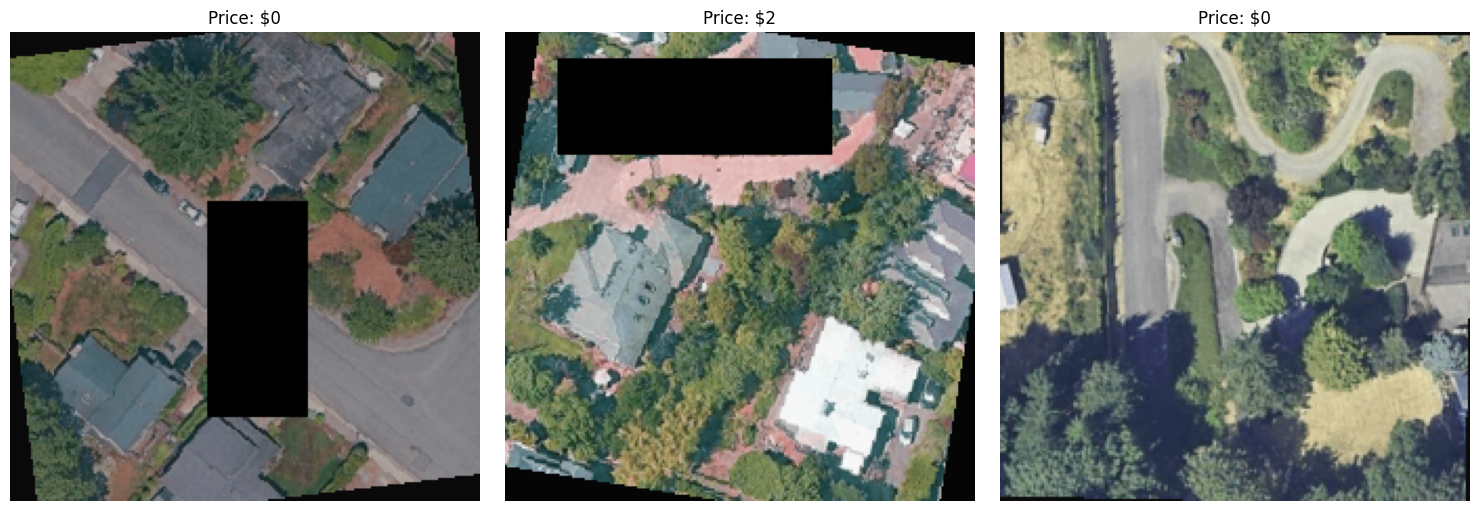

In [80]:
print("\n" + "="*70)
print("SANITY CHECK")
print("="*70)

sample_images, sample_targets = next(iter(train_loader))
print(f"✓ Batch shape: {sample_images.shape}")
print(f"✓ Target shape: {sample_targets.shape}")
print(f"Price range: ${sample_targets.min().item():,.0f} to ${sample_targets.max().item():,.0f}")
print(f"Normalised")

# Visualize a sample image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img = sample_images[i].cpu()
    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Price: ${sample_targets[i].item():,.0f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [81]:
print("\n" + "="*70)
print("MODEL SETUP")
print("="*70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ImageRegressor(dropout=0.5).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Using MSE Loss
criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)


MODEL SETUP
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s] 


Total parameters: 11,341,633
Trainable parameters: 11,341,633


The number of training epochs is adjusted based on available computational resources.

In [87]:
EPOCHS = 100
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos"
)

In [88]:
model.eval()
with torch.no_grad():
    sample_images = sample_images.to(device)
    test_output = model(sample_images)
    print(f"✓ Model output shape: {test_output.shape}")
    print(f"Sample prediction: ${test_output[0].cpu().item():,.0f}")

✓ Model output shape: torch.Size([16])
Sample prediction: $0


In [89]:
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)

In [90]:
def validate(model, loader, criterion, epocdevice):
    model.eval()
    total_loss = 0.0

    preds_norm = []
    trues_norm = []

    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images).squeeze()

            # loss in NORMALIZED space (millions)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            preds_norm.append(outputs.cpu().numpy())
            trues_norm.append(targets.cpu().numpy())

    preds_norm = np.concatenate(preds_norm)
    trues_norm = np.concatenate(trues_norm)

    # ---- de-normalize to dollars ----
    preds = preds_norm * 1e6
    trues = trues_norm * 1e6

    #metrics
    avg_loss = total_loss / len(loader)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    mae = mean_absolute_error(trues, preds)

    return avg_loss, rmse, r2, mae, preds, trues


### Training Loop

In [93]:
print("\n" + "="*70)
print("TRAINING START")
print("="*70)


train_losses = []
val_losses = []
val_rmses = []
val_r2s = []

best_rmse = float('inf')
patience = 5
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*70}")

    # ---- Train ----
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # ---- Validate ----
    val_loss, val_rmse, val_r2, val_mae, val_preds, val_trues = validate(
        model, val_loader, criterion, device
    )

    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val RMSE:   ${val_rmse:,.0f}")
    print(f"Val R²:     {val_r2:.4f}")
    print(f"Val MAE:    ${val_mae:,.0f}")


    # ---- Early stopping ----
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'val_mae': val_mae,
        }, 'best_image_model.pth')

        print(f"New best model saved! RMSE: ${best_rmse:,.0f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break



TRAINING START

Epoch 1/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0703
Val Loss:   0.0870
Val RMSE:   $294,710
Val R²:     0.1587
Val MAE:    $175,728
New best model saved! RMSE: $294,710

Epoch 2/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0686
Val Loss:   0.0715
Val RMSE:   $267,027
Val R²:     0.3093
Val MAE:    $165,216
New best model saved! RMSE: $267,027

Epoch 3/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0669
Val Loss:   0.0632
Val RMSE:   $250,908
Val R²:     0.3902
Val MAE:    $154,691
New best model saved! RMSE: $250,908

Epoch 4/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0674
Val Loss:   0.0775
Val RMSE:   $277,689
Val R²:     0.2531
Val MAE:    $179,396
No improvement. Patience: 1/5

Epoch 5/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0642
Val Loss:   0.0902
Val RMSE:   $299,913
Val R²:     0.1288
Val MAE:    $183,925
No improvement. Patience: 2/5

Epoch 6/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0627
Val Loss:   0.0562
Val RMSE:   $236,854
Val R²:     0.4566
Val MAE:    $155,080
New best model saved! RMSE: $236,854

Epoch 7/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0632
Val Loss:   0.0757
Val RMSE:   $274,588
Val R²:     0.2697
Val MAE:    $173,377
No improvement. Patience: 1/5

Epoch 8/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0608
Val Loss:   0.0668
Val RMSE:   $258,175
Val R²:     0.3544
Val MAE:    $157,830
No improvement. Patience: 2/5

Epoch 9/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0592
Val Loss:   0.0717
Val RMSE:   $267,325
Val R²:     0.3078
Val MAE:    $159,848
No improvement. Patience: 3/5

Epoch 10/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0581
Val Loss:   0.0578
Val RMSE:   $240,398
Val R²:     0.4402
Val MAE:    $151,595
No improvement. Patience: 4/5

Epoch 11/100


Training:   0%|          | 0/781 [00:00<?, ?it/s]

Validation:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 0.0576
Val Loss:   0.0718
Val RMSE:   $267,227
Val R²:     0.3083
Val MAE:    $167,341
No improvement. Patience: 5/5

Early stopping triggered after 11 epochs


In [94]:
checkpoint = torch.load(
    'best_image_model.pth',
    map_location=device,
    weights_only=False
)

### Validating Model

In [95]:
print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

val_loss, val_rmse, val_r2, val_mae, val_preds, val_trues = validate(
    model, val_loader, criterion, device
)

print("\n" + "="*70)
print("FINAL IMAGE-ONLY MODEL RESULTS")
print("="*70)
print(f"RMSE: ${val_rmse:,.0f}")
print(f"R²:   {val_r2:.4f}")
print(f"MAE:  ${val_mae:,.0f}")
print(f"MAPE: {np.mean(np.abs((np.array(val_trues) - np.array(val_preds)) / np.array(val_trues))) * 100:.2f}%")
print("="*70)

# Store results for comparison with other models
rmse_only_image = val_rmse
r2_only_image = val_r2


FINAL EVALUATION
Loaded best model from epoch 6


Validation:   0%|          | 0/196 [00:00<?, ?it/s]


FINAL IMAGE-ONLY MODEL RESULTS
RMSE: $236,854
R²:   0.4566
MAE:  $155,080
MAPE: 30.65%


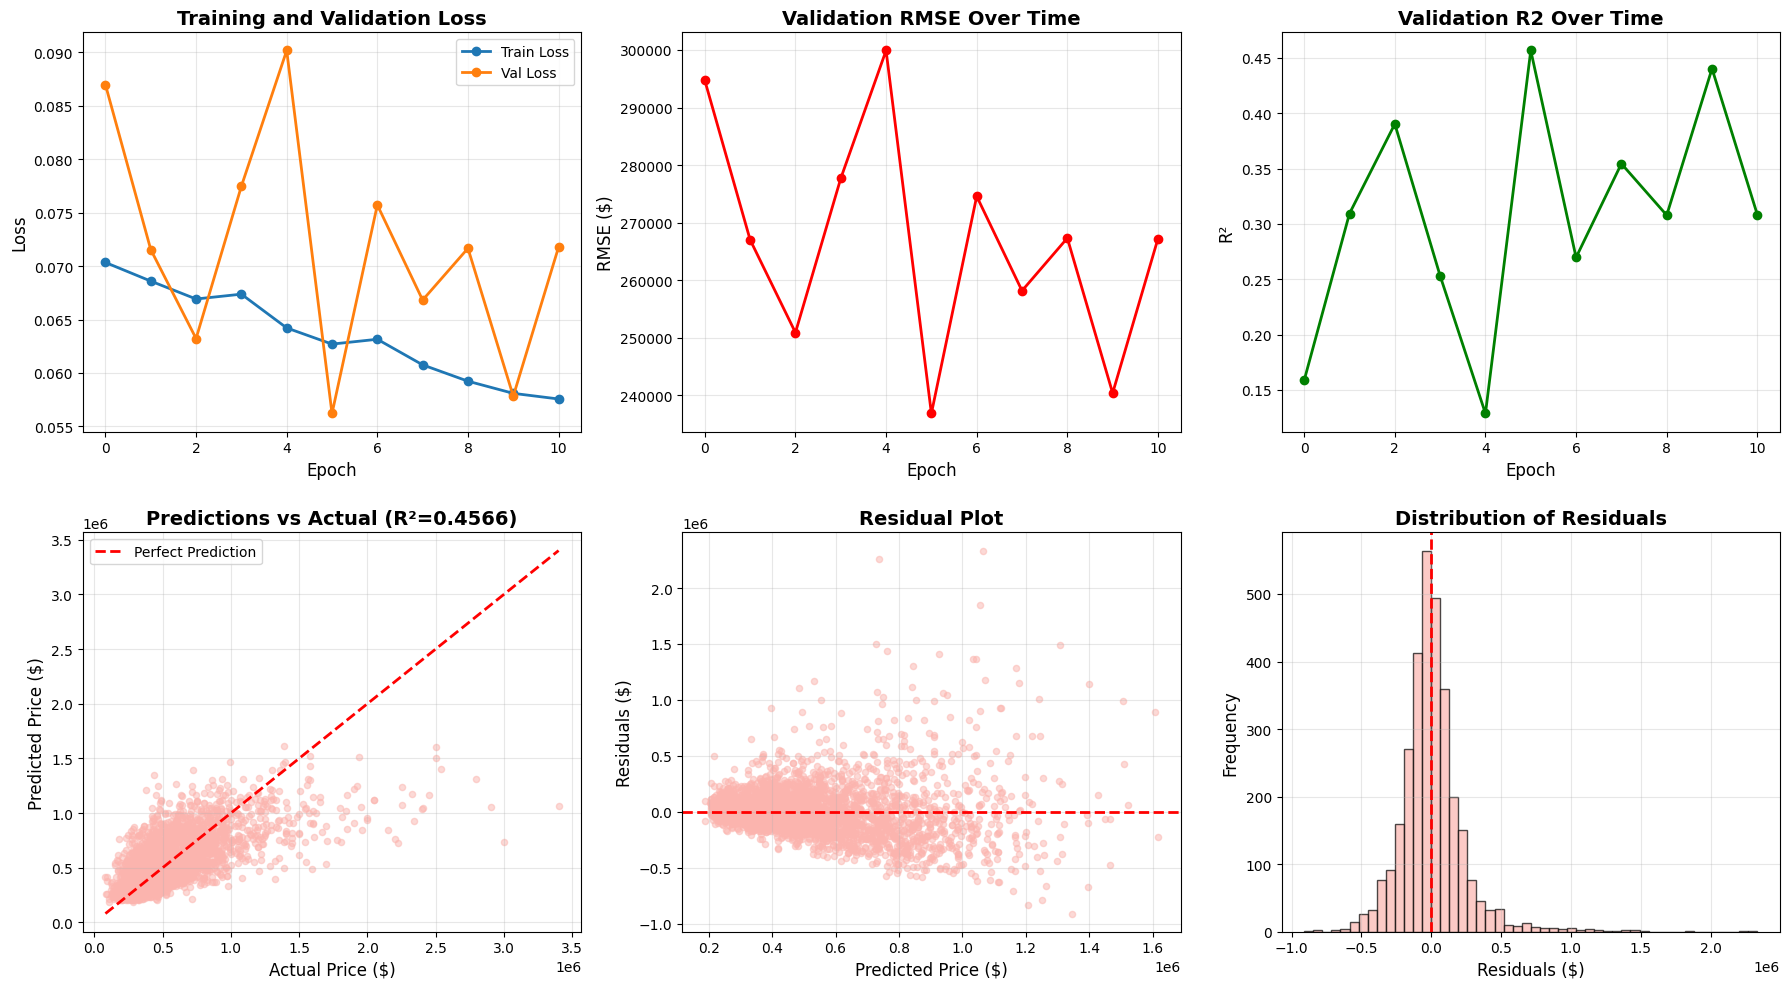


PREDICTION STATISTICS
Mean Actual Price:     $541,727
Mean Predicted Price:  $535,729
Std Actual Price:      $321,309
Std Predicted Price:   $235,166
Max Residual:          $2,335,090
Min Residual:          $54

✓ Image model variables saved: RMSE=$236,854, R2=0.4566


In [96]:
fig = plt.figure(figsize=(18, 10))

# Loss curves
ax1 = plt.subplot(2, 3, 1)
ax1.plot(train_losses, label='Train Loss', linewidth=2, marker='o')
ax1.plot(val_losses, label='Val Loss', linewidth=2, marker='o')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE curve
ax2 = plt.subplot(2, 3, 2)
ax2.plot(val_rmses, color='red', linewidth=2, marker='o')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('RMSE ($)', fontsize=12)
ax2.set_title('Validation RMSE Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# R2 curve
ax3 = plt.subplot(2, 3, 3)
ax3.plot(val_r2s, color='green', linewidth=2, marker='o')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('R²', fontsize=12)
ax3.set_title('Validation R2 Over Time', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Predictions vs Actual (scatter)
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(val_trues, val_preds, alpha=0.5, s=20,color=sns.color_palette("Pastel1")[0])
min_val = min(min(val_trues), min(val_preds))
max_val = max(max(val_trues), max(val_preds))
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Price ($)', fontsize=12)
ax4.set_ylabel('Predicted Price ($)', fontsize=12)
ax4.set_title(f'Predictions vs Actual (R²={val_r2:.4f})', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Residuals
ax5 = plt.subplot(2, 3, 5)
residuals = np.array(val_trues) - np.array(val_preds)
ax5.scatter(val_preds, residuals, alpha=0.5, s=20,color=sns.color_palette("Pastel1")[0])
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_xlabel('Predicted Price ($)', fontsize=12)
ax5.set_ylabel('Residuals ($)', fontsize=12)
ax5.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Error distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(residuals, bins=50, edgecolor='black', alpha=0.7,color=sns.color_palette("Pastel1")[0])
ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax6.set_xlabel('Residuals ($)', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("PREDICTION STATISTICS")
print("="*70)
print(f"Mean Actual Price:     ${np.mean(val_trues):,.0f}")
print(f"Mean Predicted Price:  ${np.mean(val_preds):,.0f}")
print(f"Std Actual Price:      ${np.std(val_trues):,.0f}")
print(f"Std Predicted Price:   ${np.std(val_preds):,.0f}")
print(f"Max Residual:          ${np.max(np.abs(residuals)):,.0f}")
print(f"Min Residual:          ${np.min(np.abs(residuals)):,.0f}")
print("="*70)

print(f"\n✓ Image model variables saved: RMSE=${rmse_only_image:,.0f}, R2={r2_only_image:.4f}")


In [97]:
model.eval()

images, targets = next(iter(val_loader))
images = images.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(images)

# move to cpu
preds = outputs.cpu().numpy()
trues = targets.cpu().numpy()

print("\nSample predictions (first 10):\n")
for i in range(min(10, len(preds))):
    print(f"Actual: ${trues[i].item() * 1e6:,.0f} Pred: ${preds[i].item() * 1e6:,.0f}")


Sample predictions (first 10):

Actual: $425,000 Pred: $530,483
Actual: $477,500 Pred: $268,103
Actual: $386,900 Pred: $723,728
Actual: $275,000 Pred: $327,872
Actual: $565,000 Pred: $754,968
Actual: $510,000 Pred: $482,418
Actual: $380,000 Pred: $250,838
Actual: $722,080 Pred: $658,996
Actual: $255,000 Pred: $321,250
Actual: $704,111 Pred: $520,240


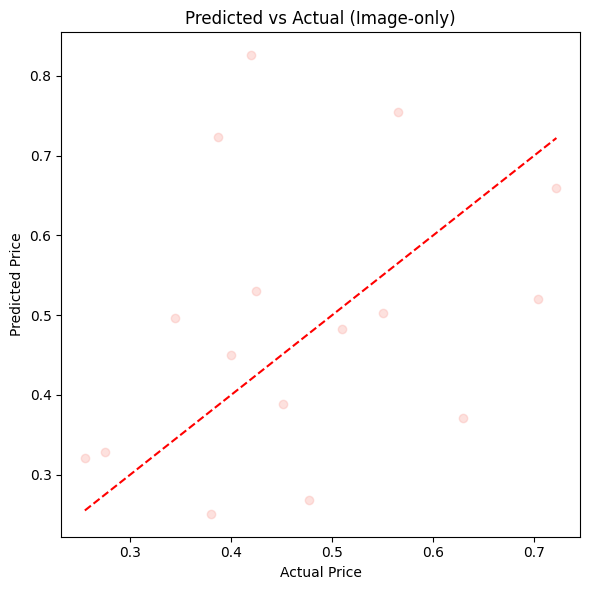

In [98]:
plt.figure(figsize=(6, 6))
plt.scatter(trues, preds, alpha=0.4,color=sns.color_palette("Pastel1")[0])
plt.plot(
    [min(trues), max(trues)],
    [min(trues), max(trues)],
    'r--'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual (Image-only)")
plt.tight_layout()
plt.show()

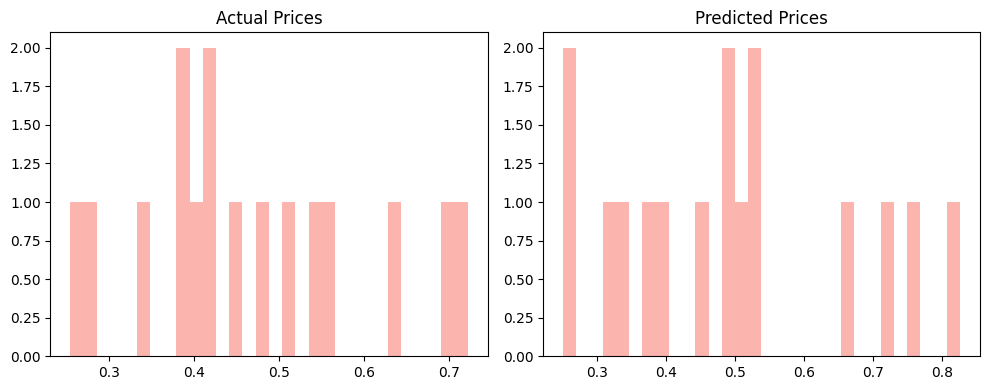

In [99]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(trues, bins=30,color=sns.color_palette("Pastel1")[0])
plt.title("Actual Prices")

plt.subplot(1, 2, 2)
plt.hist(preds, bins=30,color=sns.color_palette("Pastel1")[0])
plt.title("Predicted Prices")

plt.tight_layout()
plt.show()

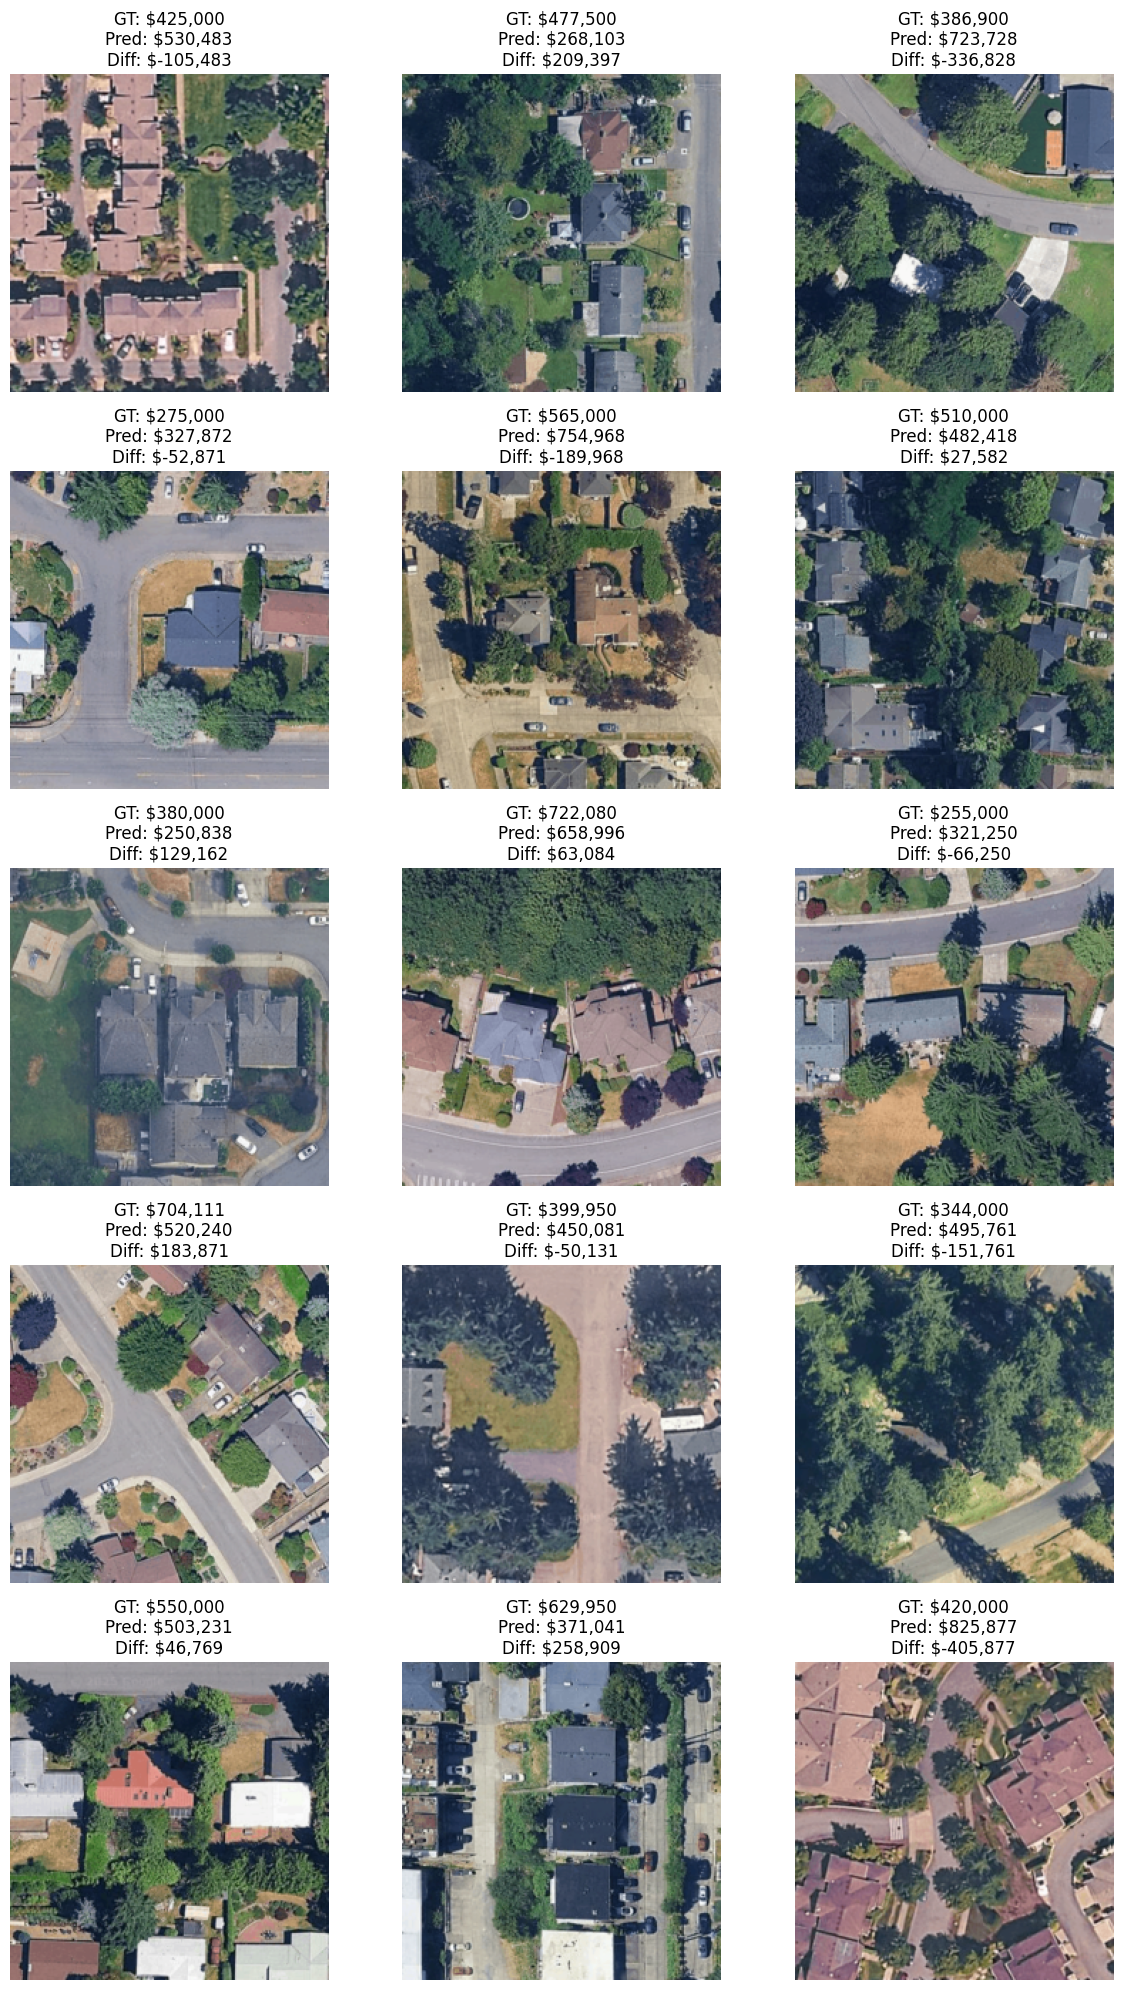

In [100]:
model.eval()
images, targets = next(iter(val_loader))

with torch.no_grad():
    preds = model(images.to(device)).cpu()

fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i, ax in enumerate(axes.flat):
    if i >= len(images):
        break

    img = images[i]
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(
        f"GT: ${targets[i].item() * 1e6:,.0f}\n"
        f"Pred: ${preds[i].item() * 1e6:,.0f}\n"
        f"Diff: ${(targets[i].item()-preds[i].item()) * 1e6:,.0f}"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [101]:
print("Pred mean:", preds.mean()*1e6)

Pred mean: tensor(492106.4688)


## Grad-Cam

In [102]:
class ImageRegressorWithFeatures(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.features = nn.Sequential(*list(trained_model.backbone.children())[:-2])
        self.pool = trained_model.backbone.avgpool
        self.fc = trained_model.backbone.fc

    def forward(self, x):
        feat = self.features(x)
        pooled = self.pool(feat).view(x.size(0), -1)
        out = self.fc(pooled)
        return out, feat

In [103]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            self.activations.requires_grad_(True)

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        input_tensor.requires_grad_(True)
        self.model.zero_grad()
        output, _ = self.model(input_tensor)
        output.backward(torch.ones_like(output))
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam

In [104]:
cam_model = ImageRegressorWithFeatures(model).to(device)
cam_model.eval()

ImageRegressorWithFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [105]:
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

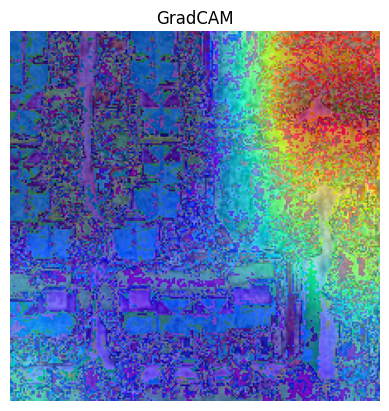

In [106]:
target_layer = cam_model.features[-1]

gradcam = GradCAM(cam_model, target_layer)

# Get sample
sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

cam = gradcam.generate(input_tensor)
cam = cam.squeeze().detach().cpu().numpy()

# Visualize (assuming you have the image)
cam_resized = F.interpolate(torch.tensor(cam).unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()
original_img = T.ToPILImage()(sample_img.cpu())
plt.imshow(original_img)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title('GradCAM')
plt.axis('off')
plt.show()

# Fusion Model

Satellite Image ──► CNN ──► Image Embedding ──┐

                                            ├─► MLP ─► Price
Tabular Features ─► MLP ─────────────────┘


In [107]:
train_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path',
       'dist_to_seattle', 'is_renovated', 'house_age', 'years_since_reno'],
      dtype='object')

In [108]:
# Load saved models
lr_model = joblib.load('lr_model.pkl')
poly_model = joblib.load('poly_model.pkl')
poly = joblib.load('poly_features.pkl')
xgb_model = joblib.load('xgb_model.pkl')
scaler_xgb = joblib.load('scaler_xgb.pkl')

In [109]:
# Load CNN model
checkpoint = torch.load('best_image_model.pth', map_location=device, weights_only=False)
cnn_model = ImageRegressor(dropout=0.5).to(device)
cnn_model.load_state_dict(checkpoint['model_state_dict'])
cnn_model.eval()

ImageRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [110]:
# Get predictions on the shared validation set
# Tabular predictions
y_pred_lr = lr_model.predict(X_val_only_tabular)
X_val_poly = poly.transform(X_val_only_tabular)
y_pred_poly = poly_model.predict(X_val_poly)
X_val_xgb_scaled = scaler_xgb.transform(X_val_only_tabular)
y_pred_xgb = xgb_model.predict(X_val_xgb_scaled)

In [111]:
# CNN predictions (need to create a dataset/loader for val_df_split)
val_dataset_fusion = HouseImageDataset(val_df_split, image_dir=IMAGE_DIR, transform=val_transform)
val_loader_fusion = DataLoader(val_dataset_fusion, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Checking for valid images...


Validating images:   0%|          | 0/3128 [00:00<?, ?it/s]

✓ Found 3128/3128 valid images


In [112]:
cnn_preds = []
with torch.no_grad():
    for images, _ in val_loader_fusion:
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        cnn_preds.extend(preds)
y_pred_cnn = np.array(cnn_preds)

In [113]:
y_pred_cnn = y_pred_cnn*1e6

In [114]:
# Fusion 1: LR + CNN
X_fusion_lr_cnn = np.column_stack([y_pred_lr, y_pred_cnn])
fusion_lr_cnn = LinearRegression()
fusion_lr_cnn.fit(X_fusion_lr_cnn, y_val_only_tabular)
y_pred_fusion_lr_cnn = fusion_lr_cnn.predict(X_fusion_lr_cnn)
rmse_fusion_lr_cnn = np.sqrt(mean_squared_error(y_val_only_tabular, y_pred_fusion_lr_cnn))
r2_fusion_lr_cnn = r2_score(y_val_only_tabular, y_pred_fusion_lr_cnn)

In [115]:
# Fusion 2: Poly + CNN
X_fusion_poly_cnn = np.column_stack([y_pred_poly, y_pred_cnn])
fusion_poly_cnn = LinearRegression()
fusion_poly_cnn.fit(X_fusion_poly_cnn, y_val_only_tabular)
y_pred_fusion_poly_cnn = fusion_poly_cnn.predict(X_fusion_poly_cnn)
rmse_fusion_poly_cnn = np.sqrt(mean_squared_error(y_val_only_tabular, y_pred_fusion_poly_cnn))
r2_fusion_poly_cnn = r2_score(y_val_only_tabular, y_pred_fusion_poly_cnn)

In [116]:
# Fusion 3: XGB + CNN
X_fusion_xgb_cnn = np.column_stack([y_pred_xgb, y_pred_cnn])
fusion_xgb_cnn = LinearRegression()
fusion_xgb_cnn.fit(X_fusion_xgb_cnn, y_val_only_tabular)
y_pred_fusion_xgb_cnn = fusion_xgb_cnn.predict(X_fusion_xgb_cnn)
rmse_fusion_xgb_cnn = np.sqrt(mean_squared_error(y_val_only_tabular, y_pred_fusion_xgb_cnn))
r2_fusion_xgb_cnn = r2_score(y_val_only_tabular, y_pred_fusion_xgb_cnn)

In [117]:
print(f"LR-CNN Fusion - RMSE: ${rmse_fusion_lr_cnn:,.0f}, R²: {r2_fusion_lr_cnn:.4f}")
print(f"Poly-CNN Fusion - RMSE: ${rmse_fusion_poly_cnn:,.0f}, R²: {r2_fusion_poly_cnn:.4f}")
print(f"XGB-CNN Fusion - RMSE: ${rmse_fusion_xgb_cnn:,.0f}, R²: {r2_fusion_xgb_cnn:.4f}")

LR-CNN Fusion - RMSE: $166,388, R²: 0.7318
Poly-CNN Fusion - RMSE: $137,771, R²: 0.8161
XGB-CNN Fusion - RMSE: $103,715, R²: 0.8958


In [118]:
# Save fusion models
joblib.dump(fusion_lr_cnn, 'fusion_lr_cnn.pkl')
joblib.dump(fusion_poly_cnn, 'fusion_poly_cnn.pkl')
joblib.dump(fusion_xgb_cnn, 'fusion_xgb_cnn.pkl')

['fusion_xgb_cnn.pkl']

In [119]:
import random
num_samples = 6
random_indices = random.sample(range(len(val_df_split)), num_samples)

In [120]:
val_dataset_vis = HouseImageDataset(val_df_split, image_dir=IMAGE_DIR, transform=val_transform)
val_loader_vis = DataLoader(val_dataset_vis, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
y_pred_cnn_full = []
with torch.no_grad():
    for images, _ in val_loader_vis:
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        y_pred_cnn_full.extend(preds)
y_pred_cnn_full = np.array(y_pred_cnn_full)

Checking for valid images...


Validating images:   0%|          | 0/3128 [00:00<?, ?it/s]

✓ Found 3128/3128 valid images


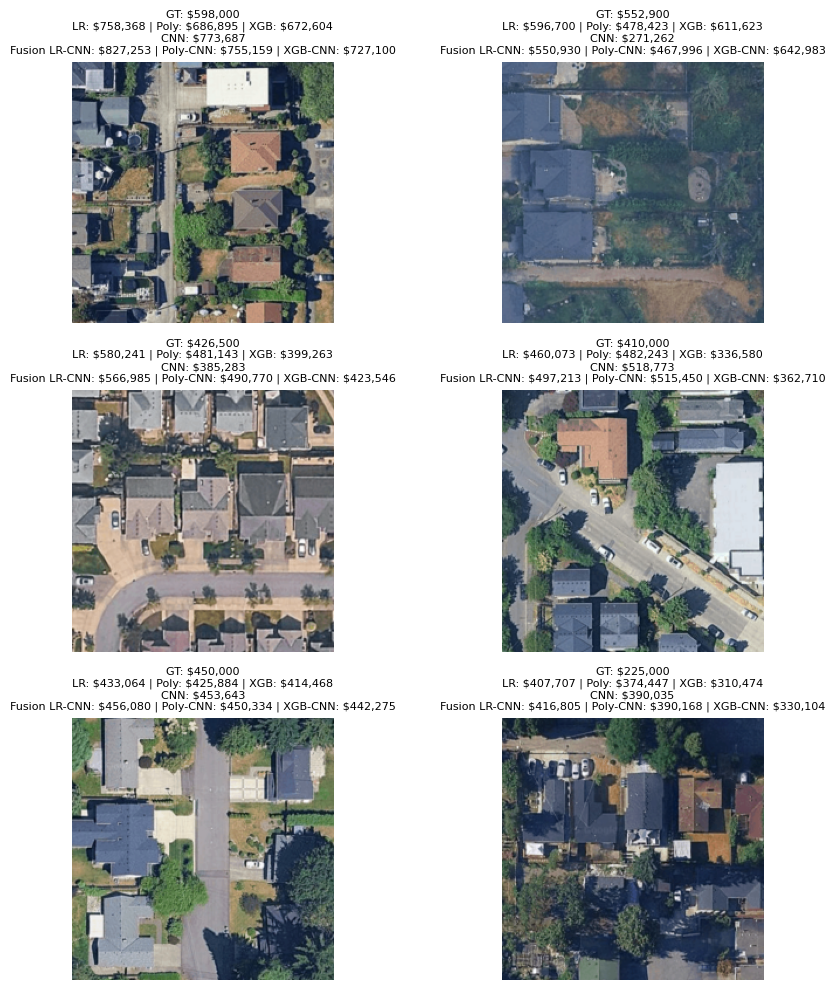

In [121]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    ax = axes.flat[i]
    
    sample_img, _ = val_dataset_vis[idx]
    img = sample_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)

    gt = y_val_only_tabular.iloc[idx]
    pred_lr = y_pred_lr[idx]
    pred_poly = y_pred_poly[idx]
    pred_xgb = y_pred_xgb[idx]
    pred_cnn = y_pred_cnn_full[idx]
    pred_fusion_lr_cnn = y_pred_fusion_lr_cnn[idx]
    pred_fusion_poly_cnn = y_pred_fusion_poly_cnn[idx]
    pred_fusion_xgb_cnn = y_pred_fusion_xgb_cnn[idx]
    
    title = (
        f"GT: ${gt:,.0f}\n"
        f"LR: ${pred_lr:,.0f} | Poly: ${pred_poly:,.0f} | XGB: ${pred_xgb:,.0f}\n"
        f"CNN: ${pred_cnn*1e6:,.0f}\n"
        f"Fusion LR-CNN: ${pred_fusion_lr_cnn:,.0f} | Poly-CNN: ${pred_fusion_poly_cnn:,.0f} | XGB-CNN: ${pred_fusion_xgb_cnn:,.0f}"
    )
    ax.set_title(title, fontsize=8) 
    ax.axis("off")

plt.tight_layout()
plt.show()

# Final Model Comparisions

In [122]:
results_df = pd.DataFrame({
    "Model": [
        "Linear Regression (Tabular)",
        "Polynomial Regression (Degree 2)",
        "XGBoost (Tabular)",
        "CNN (Image Only)",
        "Fusion LR-CNN",
        "Fusion Poly-CNN",
        "Fusion XGB-CNN"
    ],
    "RMSE": [
        rmse_only_tabular_lr,
        rmse_only_tabular_poly,
        rmse_only_tabular_xgb,
        rmse_only_image,
        rmse_fusion_lr_cnn,
        rmse_fusion_poly_cnn,
        rmse_fusion_xgb_cnn
    ],
    "R² Score": [
        r2_only_tabular_lr,
        r2_only_tabular_poly,
        r2_only_tabular_xgb,
        r2_only_image,
        r2_fusion_lr_cnn,
        r2_fusion_poly_cnn,
        r2_fusion_xgb_cnn
    ]
})

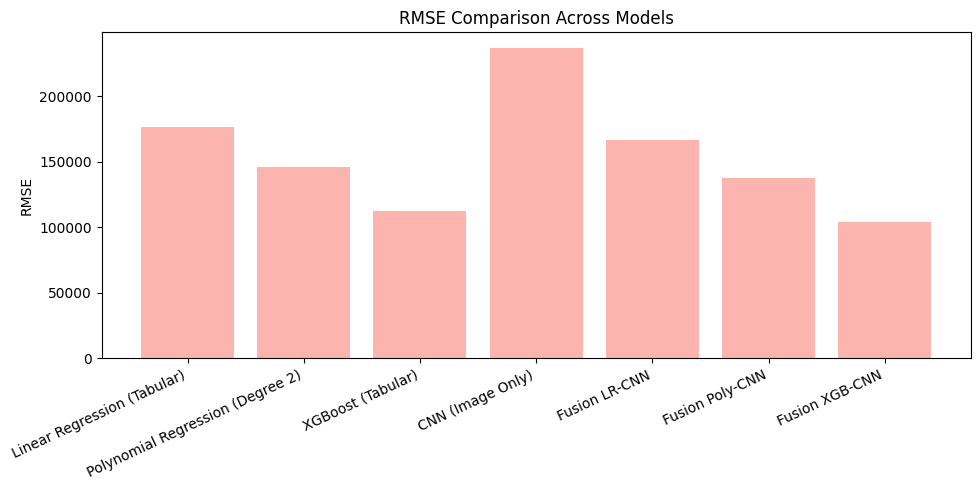

In [123]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["RMSE"],color=sns.color_palette("Pastel1")[0])
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

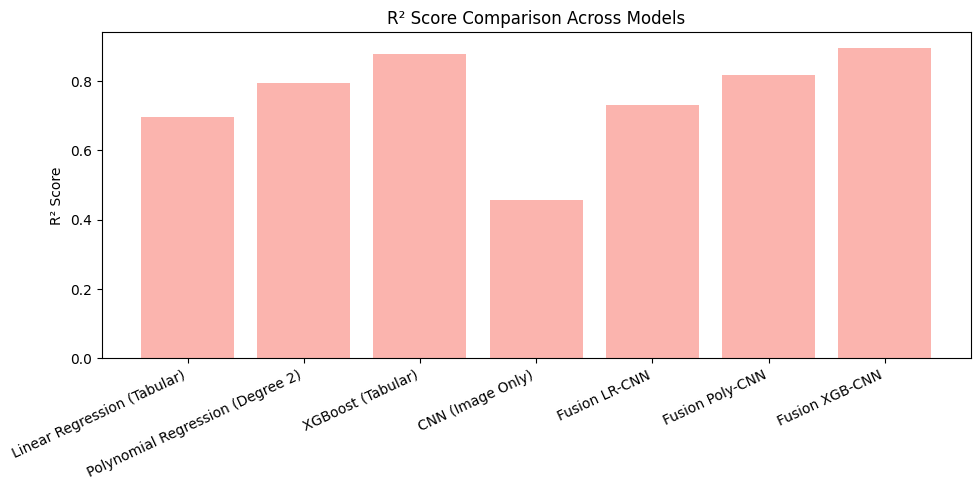

In [124]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["R² Score"],color=sns.color_palette("Pastel1")[0])
plt.ylabel("R² Score")
plt.title("R² Score Comparison Across Models")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


As expected, fusion models outperform single-modality models in the Satellite-Image-Based Property Valuation task.

Image-only CNN performs the worst, since satellite images alone cannot capture many critical property attributes.

Important factors such as number of floors, bathrooms, interior size, condition, grade, view, and waterfront access are not reliably inferable from images.

Tabular features like sqft_living, sqft_above, sqft_basement, sqft_lot, neighborhood statistics, and quality indicators carry strong predictive signals.

Fusion models (Tabular + Image) combine visual context with structured housing data, leading to lower RMSE and higher R².

Among all models, XGBoost + CNN fusion performs the best, showing that strong tabular learners benefit most from complementary image features.

Overall, these results confirm that images add value only when fused with rich tabular data, rather than used in isolation.

# Prediction

In [125]:
test_df = pd.read_csv("/kaggle/input/data-cdc/Data/test.csv")

In [126]:
test_df["house_age"] = REFERENCE_YEAR - test_df["yr_built"]
test_df['dist_to_seattle'] = np.sqrt((test_df['lat'] - 47.6062)**2 + (test_df['long'] + 122.3321)**2)

In [127]:
test_df["years_since_reno"] = np.where(
    test_df["yr_renovated"] > 0,
    REFERENCE_YEAR - test_df["yr_renovated"],
    0
)

In [128]:
X_test_tabular = test_df[TABULAR_FEATURES_tab]

In [129]:
# Load saved models
lr_model = joblib.load('lr_model.pkl')
poly_model = joblib.load('poly_model.pkl')
poly = joblib.load('poly_features.pkl')
xgb_model = joblib.load('xgb_model.pkl')
scaler_xgb = joblib.load('scaler_xgb.pkl')

In [130]:
# Load CNN model
checkpoint = torch.load('best_image_model.pth', map_location=device, weights_only=False)
cnn_model = ImageRegressor(dropout=0.5).to(device)
cnn_model.load_state_dict(checkpoint['model_state_dict'])
cnn_model.eval()

ImageRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [131]:
# Load fusion models
fusion_lr_cnn = joblib.load('fusion_lr_cnn.pkl')
fusion_poly_cnn = joblib.load('fusion_poly_cnn.pkl')
fusion_xgb_cnn = joblib.load('fusion_xgb_cnn.pkl')

### Linear Regression

In [132]:
test_pred_lr = lr_model.predict(X_test_tabular)

### Polynomial Regression

In [133]:
X_test_poly = poly.transform(X_test_tabular)
test_pred_poly = poly_model.predict(X_test_poly)

### XGBoost

In [134]:
X_test_xgb_scaled = scaler_xgb.transform(X_test_tabular)
test_pred_xgb = xgb_model.predict(X_test_xgb_scaled)

### Image only model

In [135]:
class HouseTestDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.valid_indices = []
        print("Checking for valid images...")
        for idx in tqdm(range(len(self.df)), desc="Validating images"):
            img_path = os.path.join(self.image_dir, f"{self.df.iloc[idx]['id']}.png")
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.png")
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), (128, 128, 128))
        if self.transform:
            image = self.transform(image)
        return image, row['id']

In [136]:
# CNN predictions on test images
test_dataset = HouseTestDataset(test_df, image_dir="/kaggle/input/data-cdc/Data/images_test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

test_pred_cnn = []
with torch.no_grad():
    for images, _ in test_loader:  # _ is id, not price
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        test_pred_cnn.extend(preds)
test_pred_cnn = np.array(test_pred_cnn)

Checking for valid images...


Validating images:   0%|          | 0/5404 [00:00<?, ?it/s]

✓ Found 5404/5404 valid images


In [137]:
test_pred_cnn = test_pred_cnn*1e6

In [138]:
test_pred_cnn

array([ 433022.34,  855115.8 , 1297576.9 , ...,  356682.66,  884720.3 ,
        227636.39], dtype=float32)

### Fusion Model

In [139]:
# LR-CNN
X_test_fusion_lr_cnn = np.column_stack([test_pred_lr, test_pred_cnn])
test_pred_fusion_lr_cnn = fusion_lr_cnn.predict(X_test_fusion_lr_cnn)

In [140]:
# Poly-CNN
X_test_fusion_poly_cnn = np.column_stack([test_pred_poly, test_pred_cnn])
test_pred_fusion_poly_cnn = fusion_poly_cnn.predict(X_test_fusion_poly_cnn)

In [141]:
# XGB-CNN
X_test_fusion_xgb_cnn = np.column_stack([test_pred_xgb, test_pred_cnn])
test_pred_fusion_xgb_cnn = fusion_xgb_cnn.predict(X_test_fusion_xgb_cnn)


In [142]:
# Create results DataFrame
test_results_df = pd.DataFrame({
    "id": test_df["id"],
    "lr": test_pred_lr,
    "poly": test_pred_poly,
    "xgb": test_pred_xgb,
    "cnn": test_pred_cnn,
    "fusion_lr_cnn": test_pred_fusion_lr_cnn,
    "fusion_poly_cnn": test_pred_fusion_poly_cnn,
    "fusion_xgb_cnn": test_pred_fusion_xgb_cnn
})


In [143]:
test_results_df.head()

id            lr          poly           xgb           cnn  \
0  2591820310  5.075117e+05  4.587887e+05  3.883705e+05  4.330223e+05   
1  7974200820  7.800054e+05  8.563853e+05  8.834140e+05  8.551158e+05   
2  7701450110  1.220297e+06  1.303010e+06  1.092856e+06  1.297577e+06   
3  9522300010  1.548148e+06  1.999731e+06  1.590116e+06  1.534779e+06   
4  9510861140  7.082870e+05  6.693775e+05  7.071904e+05  5.748715e+05   

   fusion_lr_cnn  fusion_poly_cnn  fusion_xgb_cnn  
0   5.159145e+05     4.779683e+05    4.139416e+05  
1   8.680310e+05     9.307215e+05    9.526111e+05  
2   1.372890e+06     1.433695e+06    1.190916e+06  
3   1.724137e+06     2.138110e+06    1.724632e+06  
4   7.301044e+05     7.033032e+05    7.557318e+05

In [144]:
# Save to CSV
test_results_df.to_csv("test_predictions_all_models.csv", index=False)
print("Test predictions saved to test_predictions_all_models.csv")

Test predictions saved to test_predictions_all_models.csv
